In [1]:
%load_ext autoreload
%autoreload 2
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

from IPython.display import display
from particle import Particle
from rich import print
from scipy.optimize import curve_fit

from python.analysis import Master, Tags, Plots, cross_section, Fitting

cross_section.SetPlotStyle(dpi = 140)

In [2]:
photon_file = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5"
path = "work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/"

# photon_file = "work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/photon_energies.hdf5"
# path = "work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/"

df = pd.read_hdf(photon_file, "all_photons")
df["residual"] = df.reco_energy - df.true_energy
df["fractional_error"] = (df.reco_energy / df.true_energy) - 1
display(df)

save = True

if save is True:
    os.makedirs(path, exist_ok = True)

energy_range = (0, 1500)

,reco_direction_x,reco_direction_y,reco_direction_z,true_direction_x,true_direction_y,true_direction_z,reco_startPos_x,reco_startPos_y,reco_startPos_z,true_startPos_x,true_startPos_y,true_startPos_z,reco_showerLength,reco_nHits,reco_nHits_collection,reco_energy,true_energy,true_mother,residual,fractional_error
0,-0.573658,-0.650870,0.497277,-0.653672,-0.430858,0.622153,-60.968365,400.804504,100.507202,-47.542348,413.603266,72.256046,54.119766,243,64,133.802572,268.863259,111,-135.060687,-0.502340
1,-0.582882,-0.150411,0.798515,-0.454243,0.011511,0.890803,-66.354073,392.015533,159.645737,-66.890294,394.121395,141.187528,90.962692,279,65,124.191339,239.771747,111,-115.580408,-0.482043
2,-0.459984,-0.684339,0.565770,-0.586435,-0.440060,0.680030,-100.044380,364.179871,189.802383,-66.890294,394.121395,141.187528,27.070080,211,66,132.847502,285.849104,111,-153.001602,-0.535253
3,-0.898962,-0.344144,-0.270984,-0.928070,-0.303243,-0.216172,-44.448273,407.472321,96.564964,-44.510468,412.664851,82.987064,100.599869,479,129,328.793293,224.074700,111,104.718593,0.467338
4,-0.328594,-0.186096,0.925956,-0.129380,-0.200225,0.971170,-41.358082,409.369537,86.205284,-45.973625,411.541706,69.810615,101.090866,1035,379,879.634345,471.734177,111,407.900167,0.864682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12189,0.423831,-0.540510,0.726785,0.381663,-0.465049,0.798788,-45.125404,410.972870,88.335129,-51.295383,412.947464,69.588852,133.226486,892,245,545.426464,531.016507,111,14.409957,0.027137
12190,-0.267597,0.195847,0.943417,0.296699,0.273622,0.914932,-31.145397,408.991272,101.809914,-45.032495,407.864880,83.039338,161.235443,957,324,516.226603,335.723310,111,180.503293,0.537655
12191,-0.363956,-0.018690,0.931229,-0.012479,0.398380,0.917136,-37.448414,402.892731,98.215187,-45.884278,400.467184,85.243965,205.699539,825,266,565.426627,385.056909,111,180.369718,0.468424
12192,0.277532,-0.257808,-0.925479,0.049908,-0.646231,-0.761508,-47.679783,388.351746,98.571678,-51.639056,397.012241,96.694203,20.195688,93,30,35.134860,90.807447,111,-55.672587,-0.613084


In [3]:
pdf = Plots.PlotBook(path + "plots.pdf", save)

pdf work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/plots.pdf has been opened


# Selection

{'pi0_daughter': 10718, 'other': 1476}

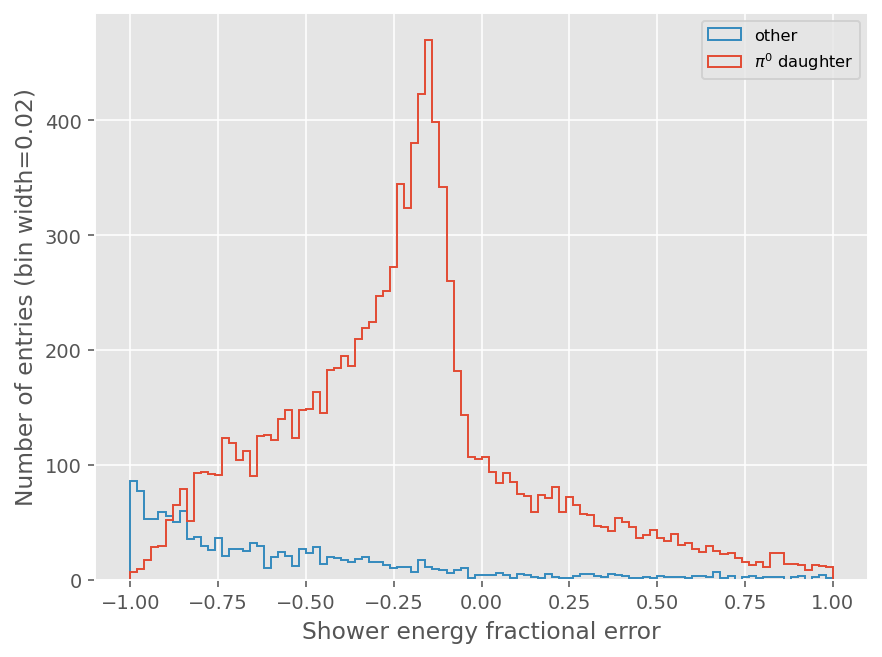

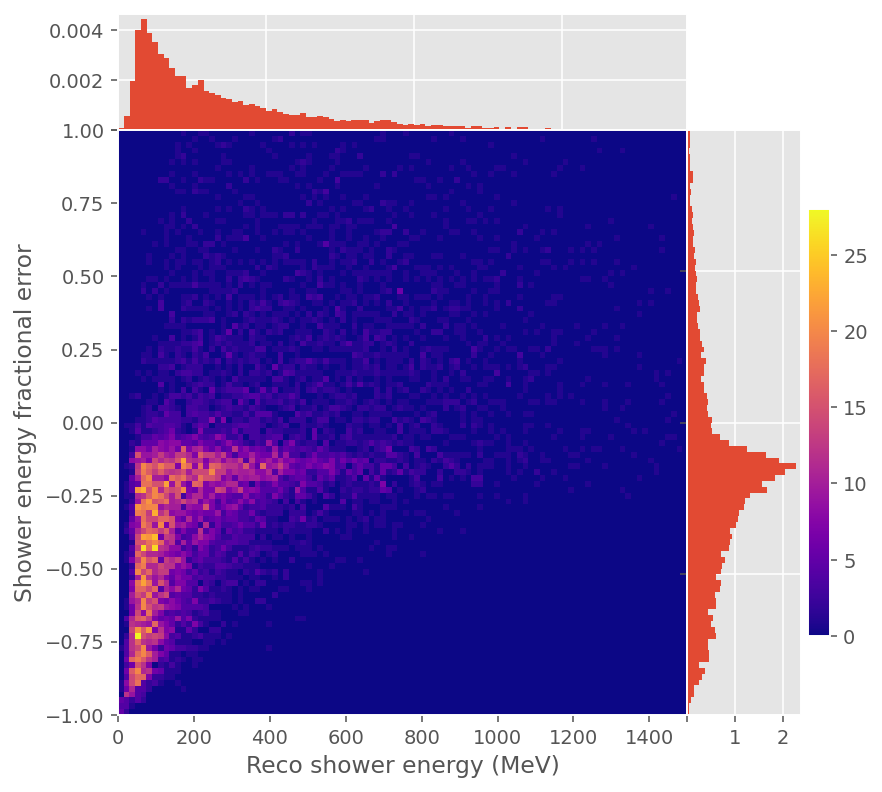

In [4]:
pi0_mother = df.true_mother == 111
counts = {"pi0_daughter" : len(pi0_mother[pi0_mother]), "other" : len(pi0_mother) - len(pi0_mother[pi0_mother])}
print(counts)

Plots.PlotHist([df[pi0_mother].fractional_error, df[~pi0_mother].fractional_error], stacked = False, histtype = "step", range = [-1, 1], xlabel = "Shower energy fractional error", label = ["$\pi^{0}$ daughter", "other"])
pdf.Save()

df = df[pi0_mother]
Plots.PlotHist2DImshowMarginal(df.reco_energy, df.fractional_error, bins = 100, xlabel = "Reco shower energy (MeV)", ylabel = "Shower energy fractional error", cmap = "plasma", x_range = [0, 1500], y_range = [-1, 1], norm = False)
pdf.Save()

# Linear Correction

In [5]:
def LinearFit(x, m):
    return m * x

def binned_dataframe(bins : list) -> list:
    """ split a dataframe into a list of dataframes based on reco energy bins

    Args:
        bins (list): bin edges

    Returns:
        list: list of binned data frames
    """
    binned_data = []
    for i in range(1, len(bins)):
        data = df[(df.reco_energy < bins[i]) & (df.reco_energy > bins[i-1])]
        binned_data.append(data[data.true_energy < max(energy_range)])
    return binned_data


def linear_fit(bins : list) -> float:
    """ perform linear fit of true energy vs reco energy, equivalent to the correction done in the microboone simulation paper.

    Args:
        bins (list): reco energy bins

    Returns:
        float: gradient of linear fit (correction)
    """
    x = (bins[1:] + bins[:-1]) / 2
    y = np.array([d.true_energy.mean() for d in binned_dataframe(bins)])

    popt, pcov = curve_fit(LinearFit, x, y)

    print(popt, pcov**0.5)
    perr = np.array([pcov[i][i] for i in range(len(popt))])**0.5

    Plots.Plot(x, y, marker = "x", linestyle = "")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit")
    plt.fill_between(x, LinearFit(x, *(popt + perr)), LinearFit(x, *(popt - perr)), color = "C3", alpha = 0.5)
    Plots.Plot(x, x, newFigure = False, label = "$y = x$", xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)")
    plt.legend()


    Plots.PlotHist2D(df.true_energy, df.reco_energy, x_range = [0, 1500], y_range = [0, 1500], cmap = "summer")
    Plots.Plot(x, LinearFit(x, *popt), newFigure = False, label = "fit", color = "C0")
    Plots.Plot(x, x, newFigure = False, color = "black", label = "$y = x$")
    Plots.Plot(x, y, marker = "x", linestyle = "", ylabel = "True shower energy (MeV)", xlabel = "Reco shower energy (MeV)", newFigure = False, color = "C0")
    # if save is True: Plots.Save("linear_correction_fit", path)
    pdf.Save()
    return popt[0]


def LinearFitPerformance(linear_correction : float):
    """ Performance plots and metrics of linear correction.

    Args:
        linear_correction (float): correction from fit
    """
    corrected_energy = cross_section.EnergyCorrection.LinearCorrection(df.reco_energy, linear_correction)

    fe = (df.reco_energy / df.true_energy) - 1
    fec = (corrected_energy / df.true_energy) - 1

    print(f"correction factor : {linear_correction}")
    print(f"mean shower energy fractional error: {np.mean(fe)} +- {np.std(fe)}")
    print(f"mean shower energy fractional error after correction: {np.mean(np.mean(fec))} +- {np.std(fec)}")

    Plots.PlotHistComparison([df.reco_energy, corrected_energy], labels = ["uncorrected", "corrected"], x_range = [0, 2000], xlabel = "Shower energy (MeV)")
    Plots.PlotHistComparison([df.reco_energy - df.true_energy, corrected_energy - df.true_energy], labels = ["uncorrected", "corrected"], x_range=[-500, 500], xlabel = "Shower energy residual (MeV)")
    # if save is True: Plots.Save("linear_correction_residual", path)
    pdf.Save()

    Plots.PlotHist2DComparison([df.true_energy, df.true_energy], [fe, fec], [0, 2000], [-1, 1], bins = 50, cmap = "Accent", xlabels = ["True shower energy (MeV)"]*2, ylabels = ["Fractional error"]*2, titles = ["uncorrected", "corrected"])
    pdf.Save()
    return

[0.83115334] [[0.03109771]]

correction factor : 0.8311533388137958

mean shower energy fractional error: -0.1637734431656845 +- 0.487370597998481

mean shower energy fractional error after correction: 0.006103829201672997 +- 0.5863786803696726

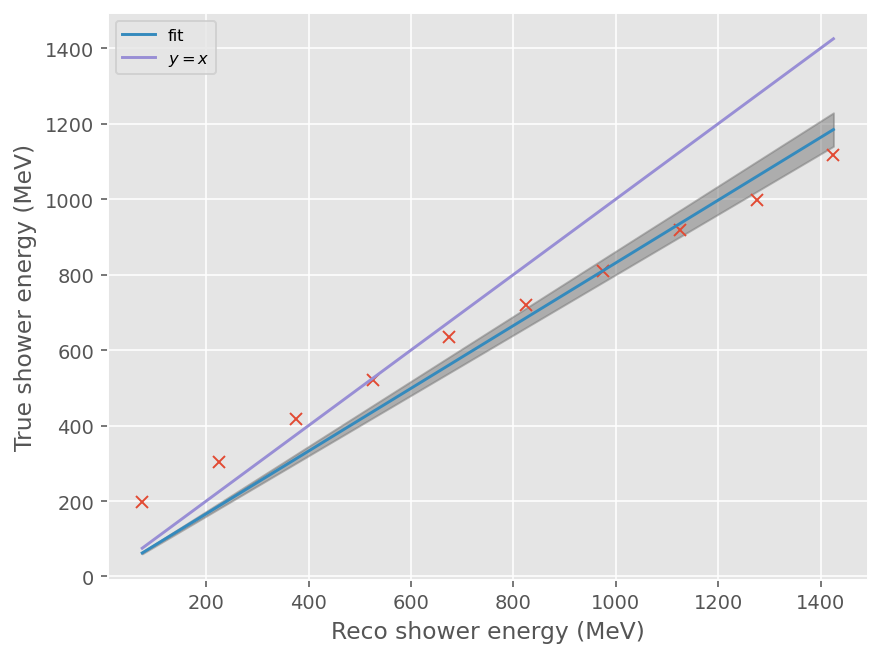

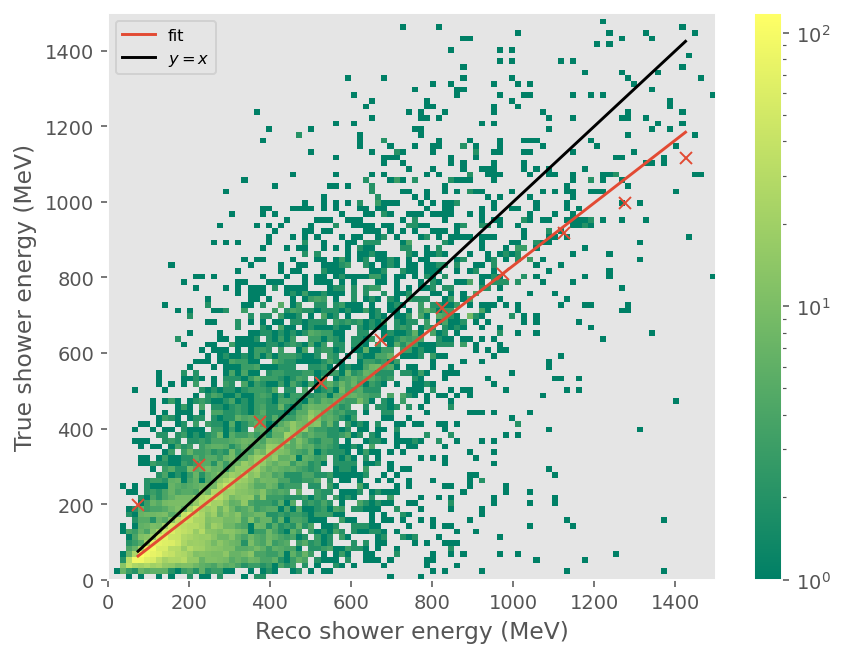

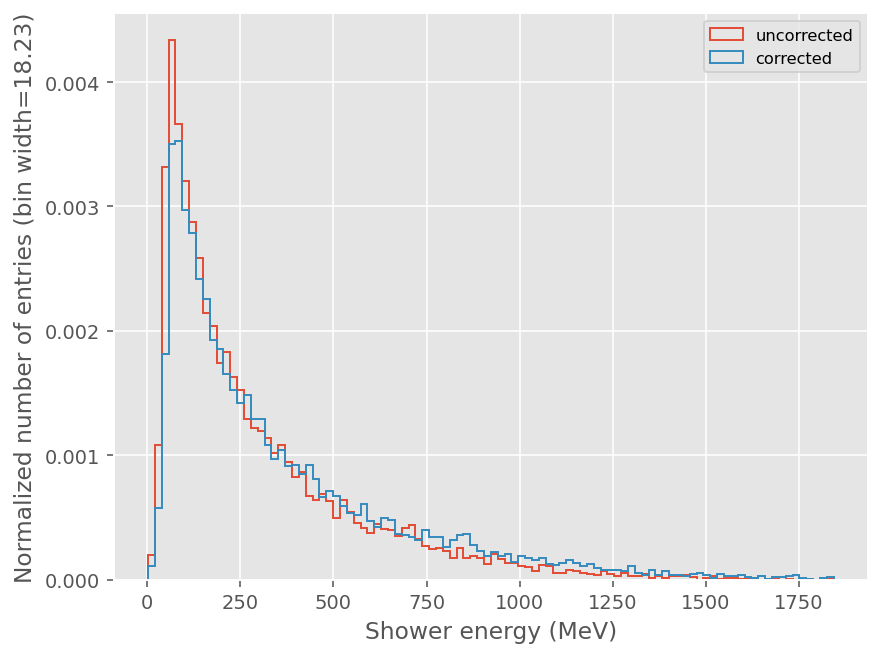

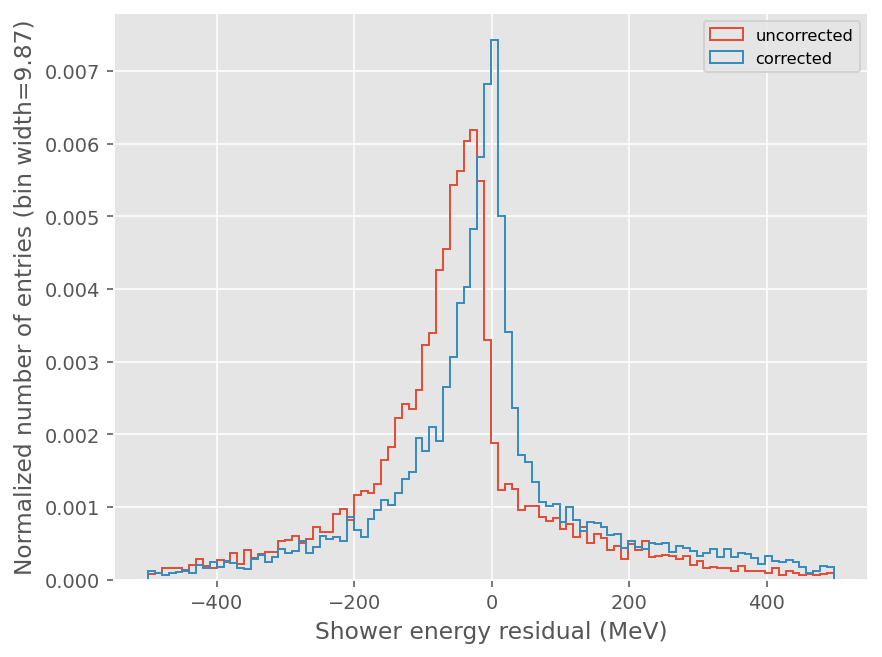

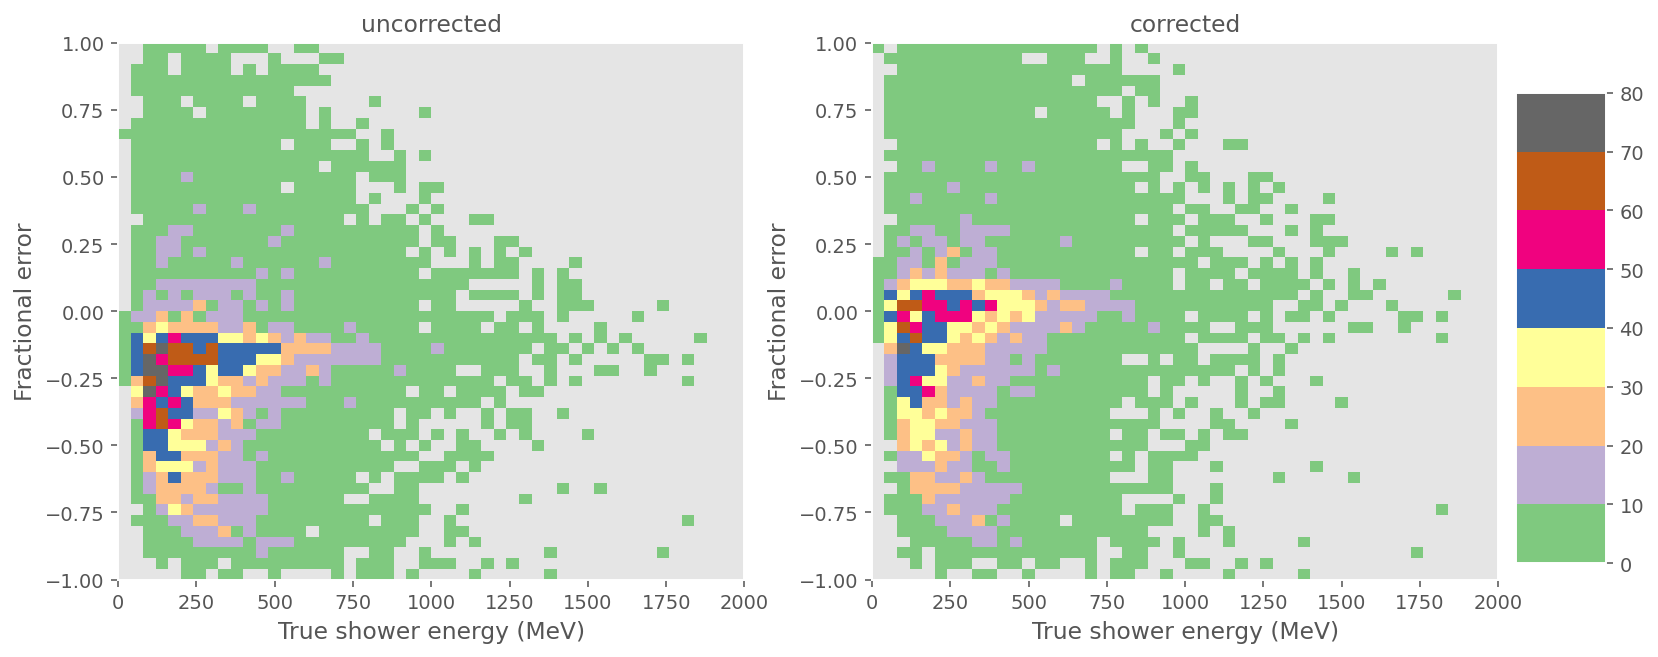

In [6]:
bins = np.linspace(min(energy_range), max(energy_range), 11)
linear_correction = linear_fit(bins)
LinearFitPerformance(linear_correction)

# Response correction

In [7]:
def IterBinnedDF(variable : str, v_range: list, reco_bins : list) -> pd.DataFrame:
    for i in range(1, len(reco_bins)):
        binned_data = df[(df.reco_energy > reco_bins[i-1]) & (df.reco_energy < reco_bins[i])]
        ranged_data = binned_data[(binned_data[variable] > min(v_range)) & (binned_data[variable] < max(v_range))]
        yield ranged_data[variable]


def calculate_mean(variable : str, v_range: list, reco_bins : list):
    means = []
    for column in IterBinnedDF(variable, v_range, reco_bins):
        means.append(column.mean())
    return np.array(means)


def calculate_sem(variable : str, v_range: list, reco_bins : list):
    sem = []
    for column in IterBinnedDF(variable, v_range, reco_bins):
        sem.append(column.std() / np.sqrt(len(column)))
    return np.array(sem)

def create_bins_df(value : pd.Series, n_entries, v_range : list = None):
    sorted_value = value.sort_values()
    n_bins = len(sorted_value) // n_entries

    bins = []
    for i in range(n_bins + 1):
        mi = sorted_value.values[i * n_entries]
        bins.append(mi)
    if v_range:
        bins[0] = min(v_range)
        bins[-1] = max(v_range)
    return np.array(bins)


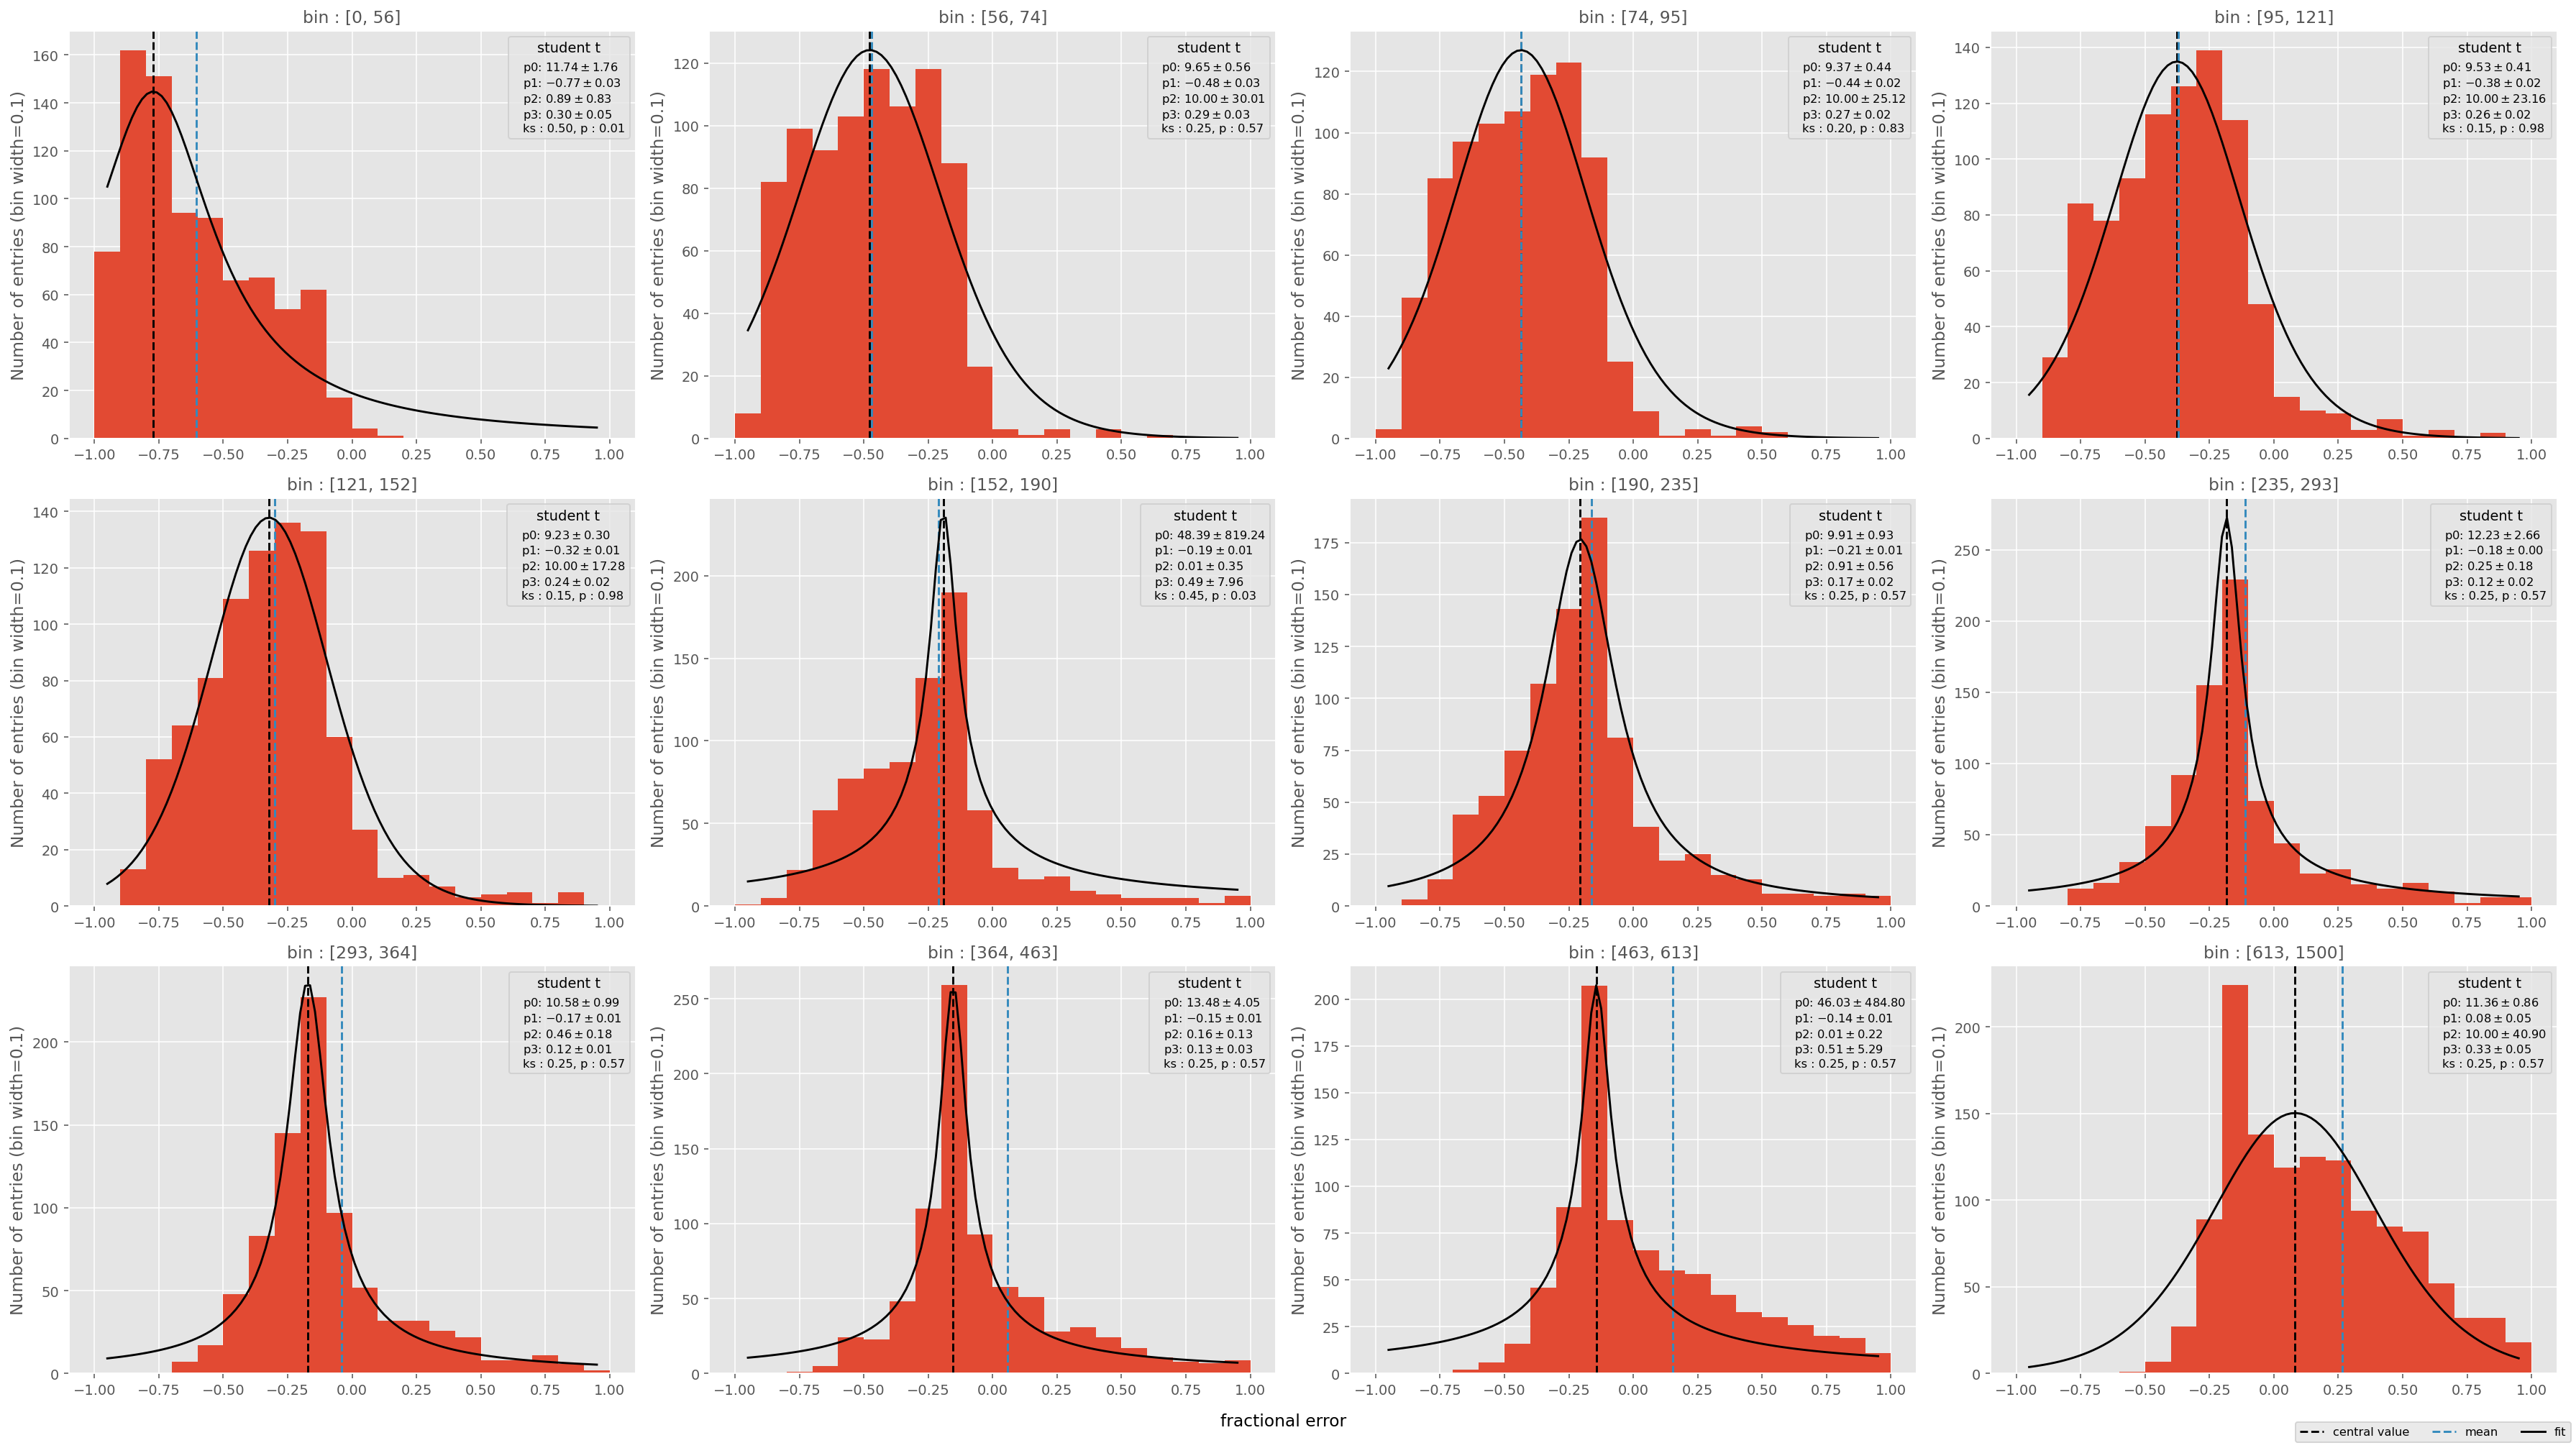

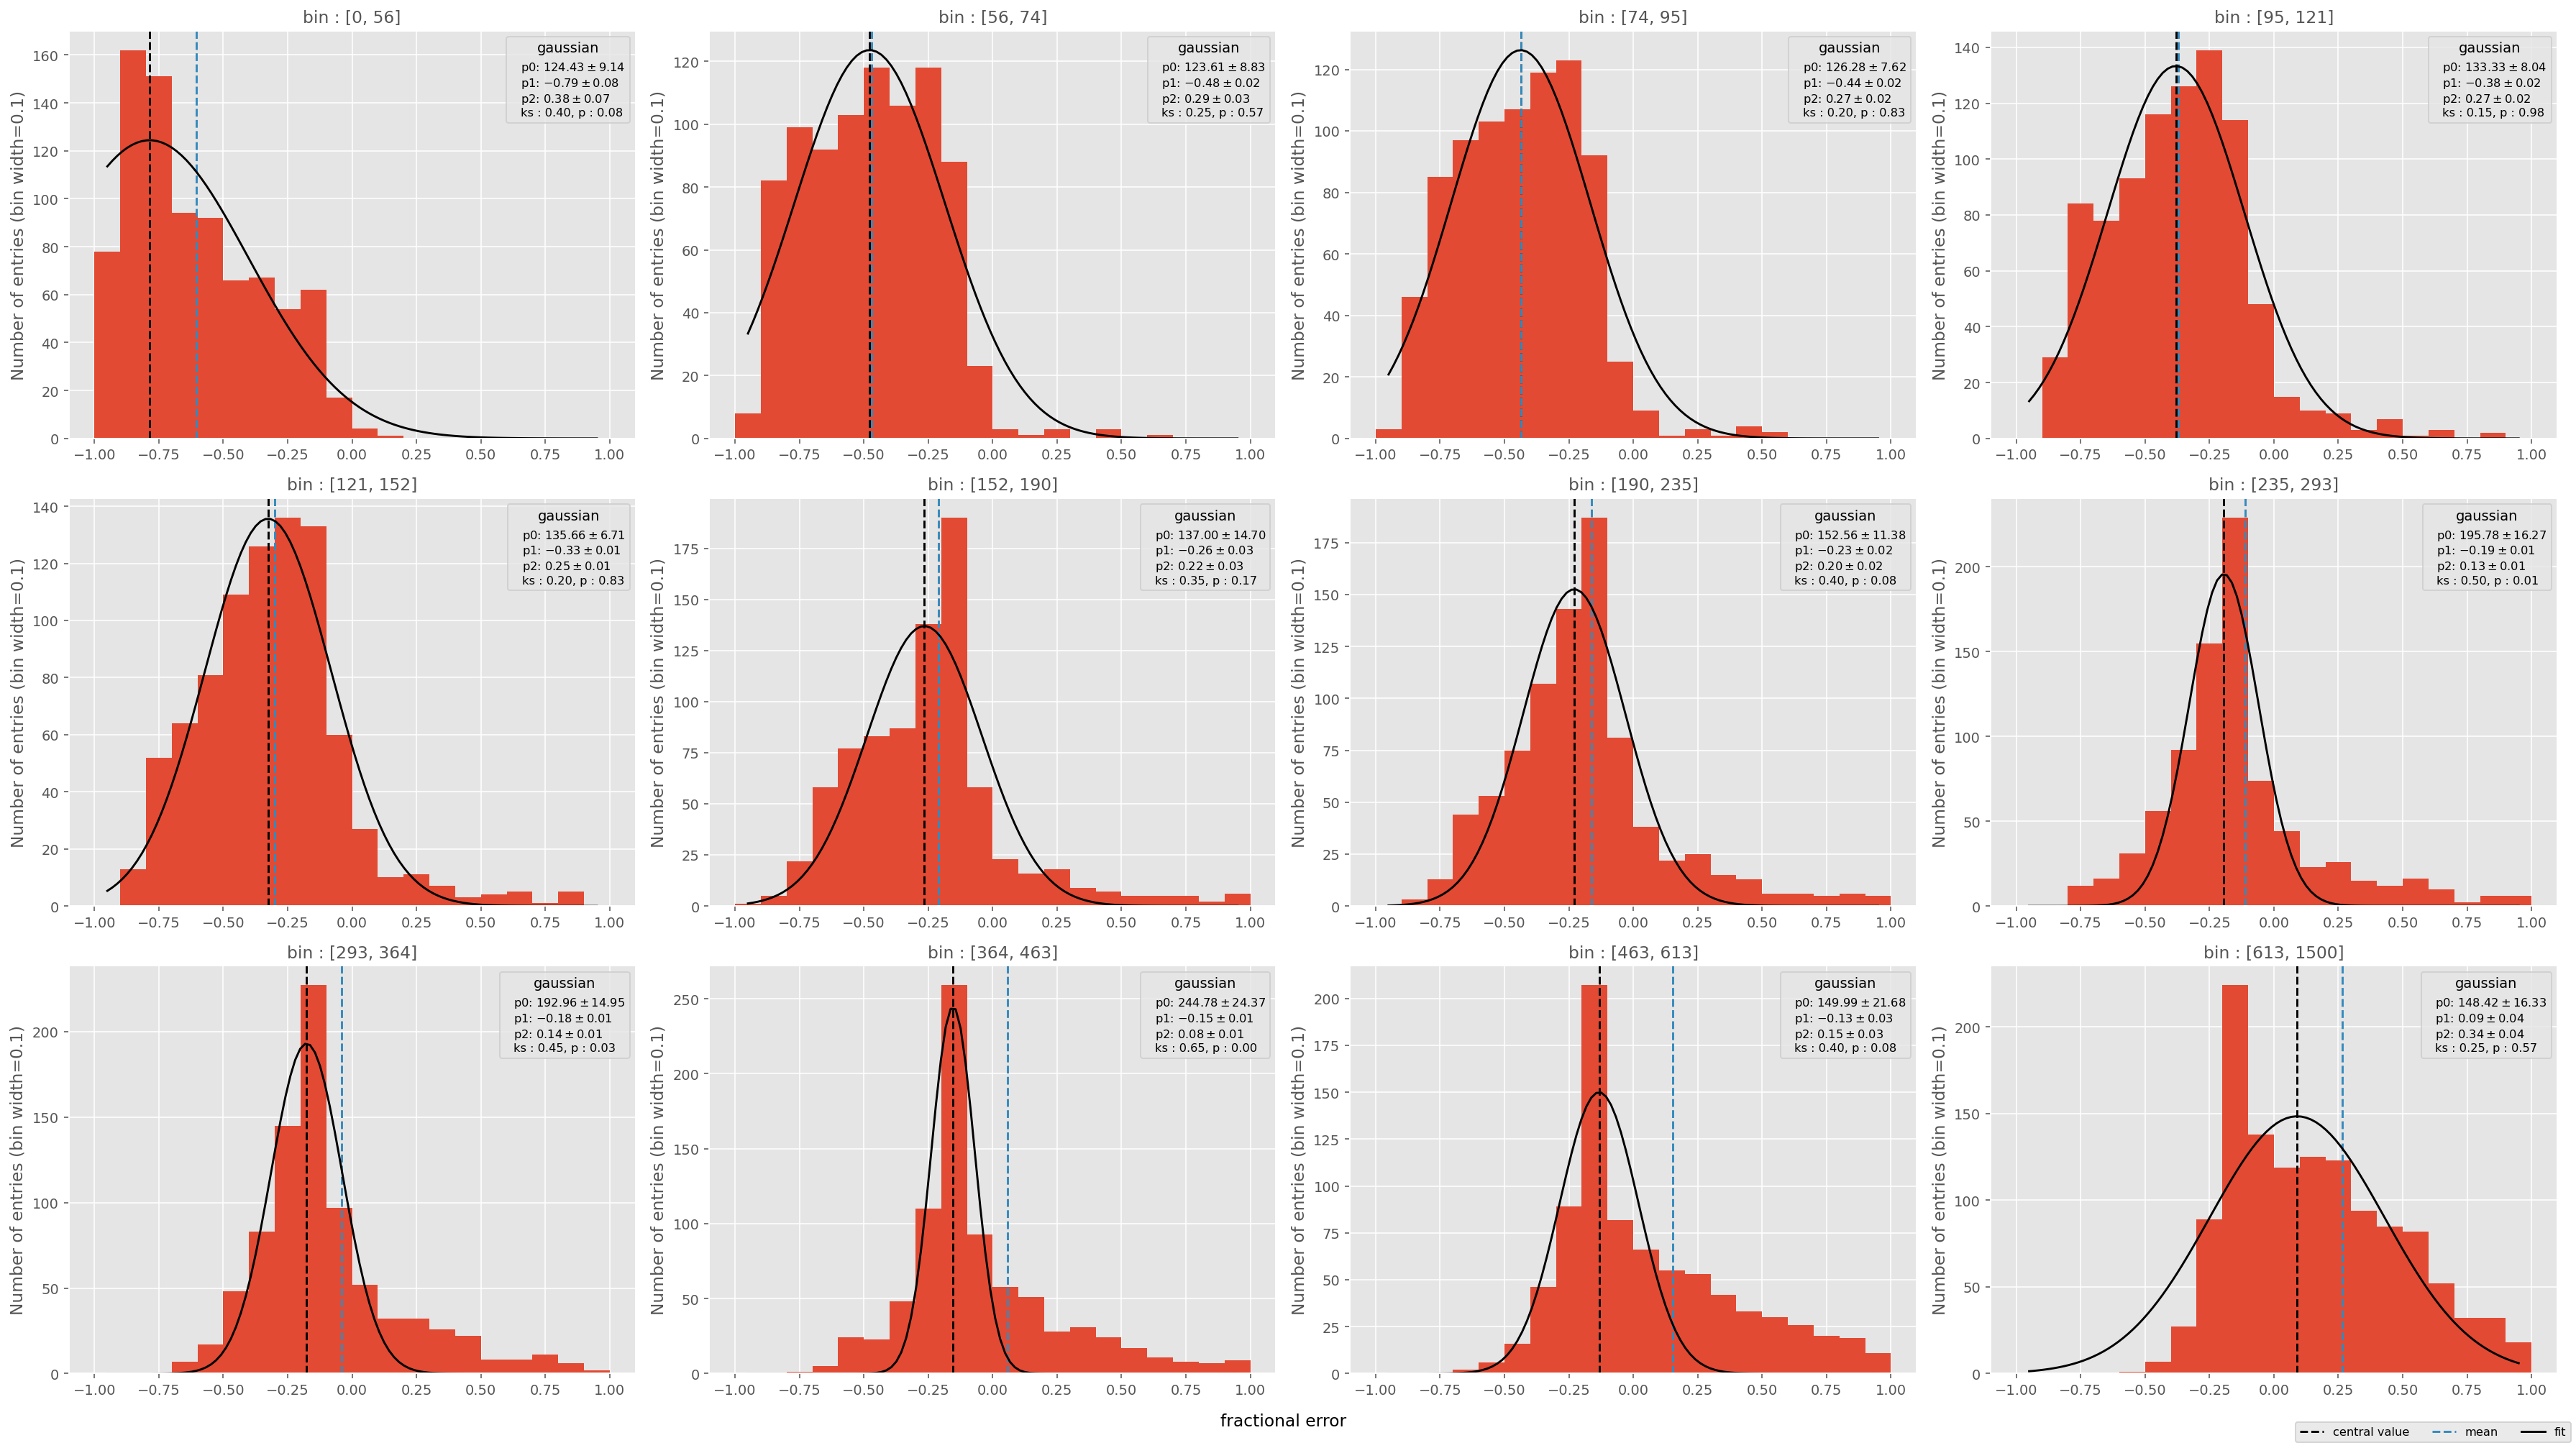

In [8]:
bins = np.array(create_bins_df(df.reco_energy, 850, energy_range), dtype = int)

central_values = {}

central_values["student_t"] = Fitting.ExtractCentralValues_df(df, "reco_energy", "fractional_error", [-1, 1], [Fitting.student_t], bins, 20)
pdf.Save()
central_values["gaussian"] = Fitting.ExtractCentralValues_df(df, "reco_energy", "fractional_error", [-1, 1], [Fitting.gaussian], bins, 20)
pdf.Save()
central_values["mean"] = [calculate_mean("fractional_error", [-1, 1], bins), calculate_sem("fractional_error", [-1, 1], bins)]
pdf.Save()

# central_values = {
#     "student_t" : Fitting.ExtractCentralValues_df(df, "reco_energy", "fractional_error", [-1, 1], [Fitting.student_t], bins, 20),
#     "gaussian" : Fitting.ExtractCentralValues_df(df, "reco_energy", "fractional_error", [-1, 1], [Fitting.gaussian], bins, 20),
#     # "double_gaussian" : fit_regions("fractional_error", [-1, 1], [double_gaussian], bins, 20),
#     "mean" : [calculate_mean("fractional_error", [-1, 1], bins), calculate_sem("fractional_error", [-1, 1], bins)]
#     }

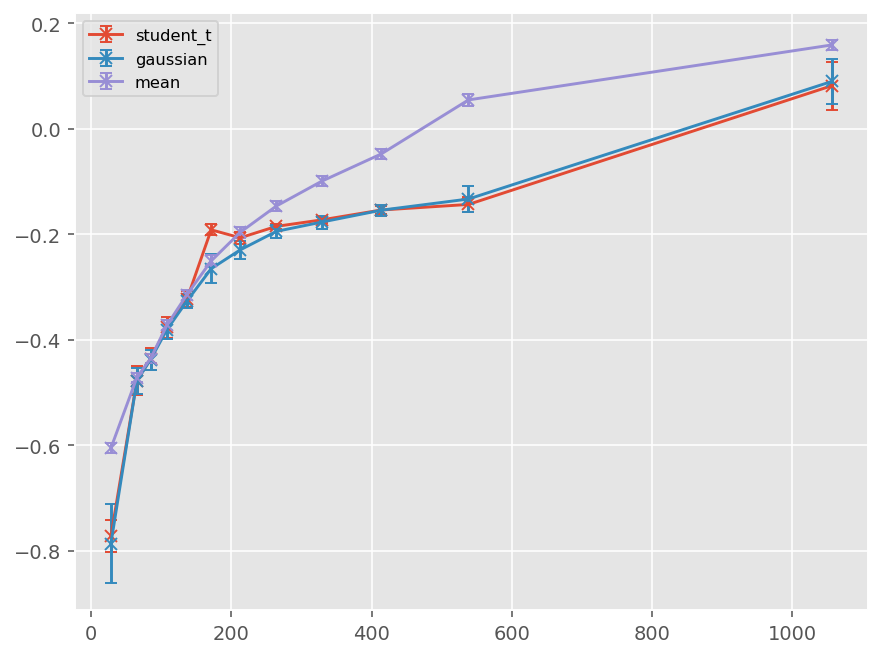

In [9]:
x = (bins[1:] + bins[:-1]) / 2
for i, cv in enumerate(central_values):
    Plots.Plot(x, np.array(central_values[cv][0], dtype = float), yerr = np.array(central_values[cv][1], dtype = float), marker = "x", label = cv, color = f"C{i}", newFigure = False)

## fractional error fit

student_t

[0.0303493  0.02722605 0.0212608  0.01988567 0.01458632 0.01069665
 0.01167245 0.00481022 0.0052971  0.00690111 0.01483208 0.04521391]

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:93: RuntimeWarning: invalid value encountered in log
  return p0 * np.log(x - p1) + p2


gaussian

[0.0753111  0.0242989  0.01881443 0.01847528 0.01399036 0.02770829
 0.01710101 0.01294484 0.01239996 0.01005995 0.02551732 0.04311175]

mean

[0.0088085  0.00842061 0.0084624  0.00900848 0.00954485 0.01036171
 0.01026575 0.0100158  0.00962357 0.01034465 0.01183319 0.00905827]

{
    'student_t': array([ 0.1211132 , 26.04417618, -0.85869159]),
    'gaussian': array([ 0.15228145, 22.76511051, -1.04841441]),
    'mean': array([  0.25506107, -18.83324749,  -1.59699966])
}

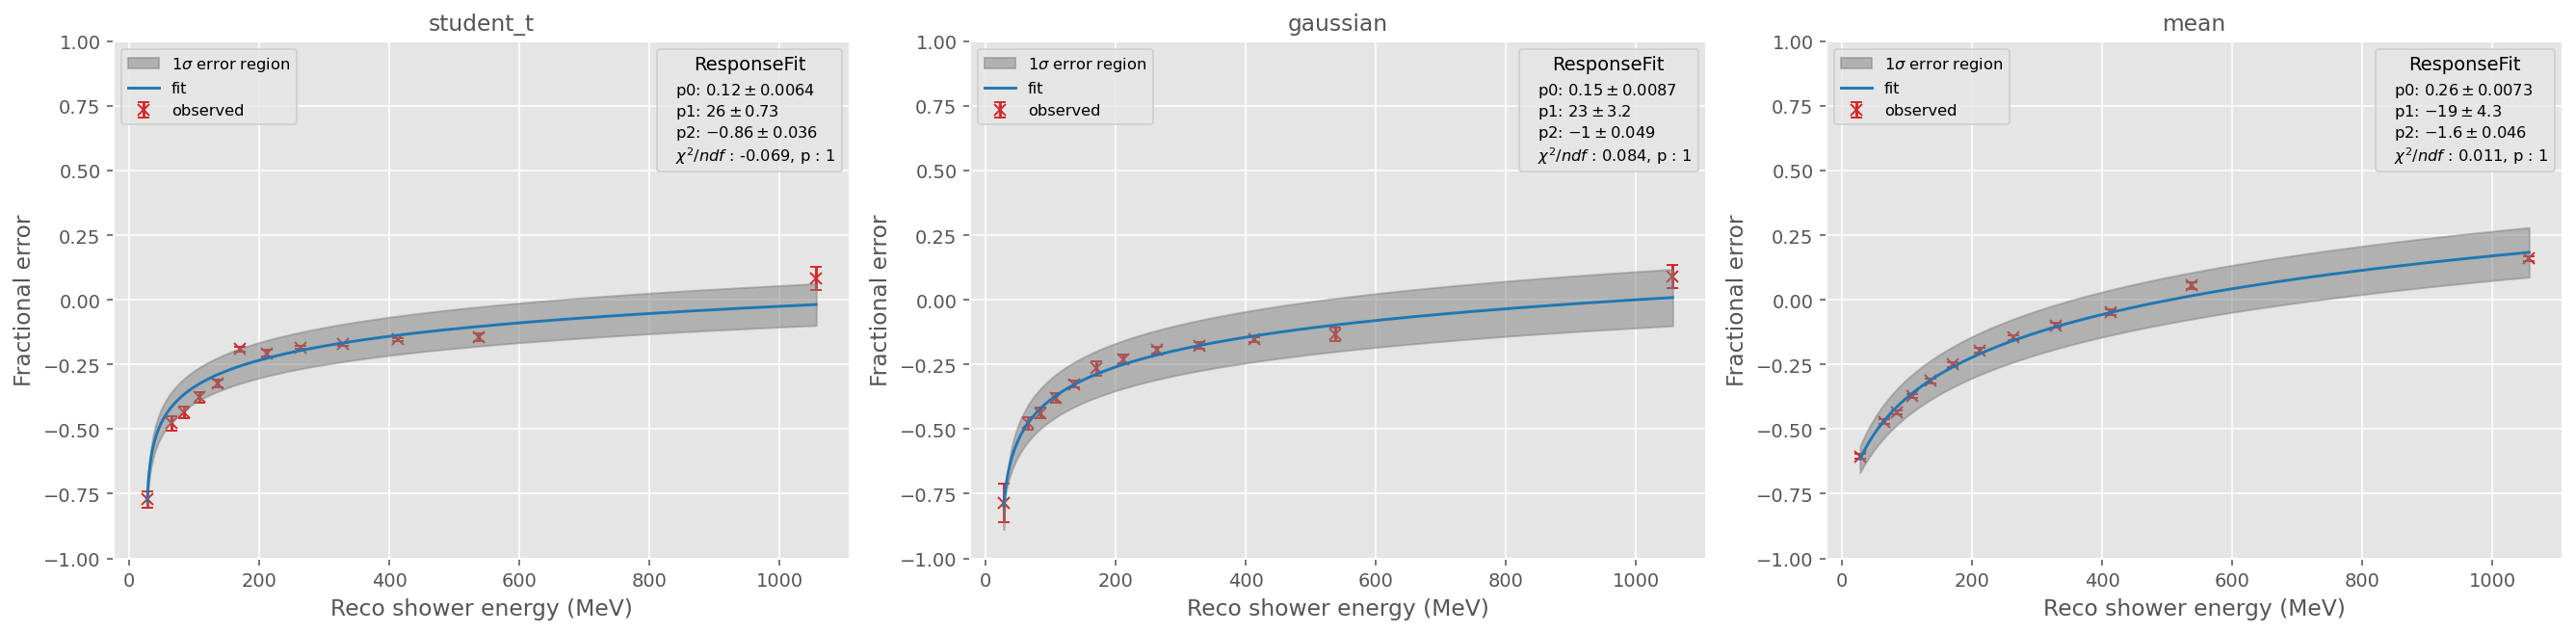

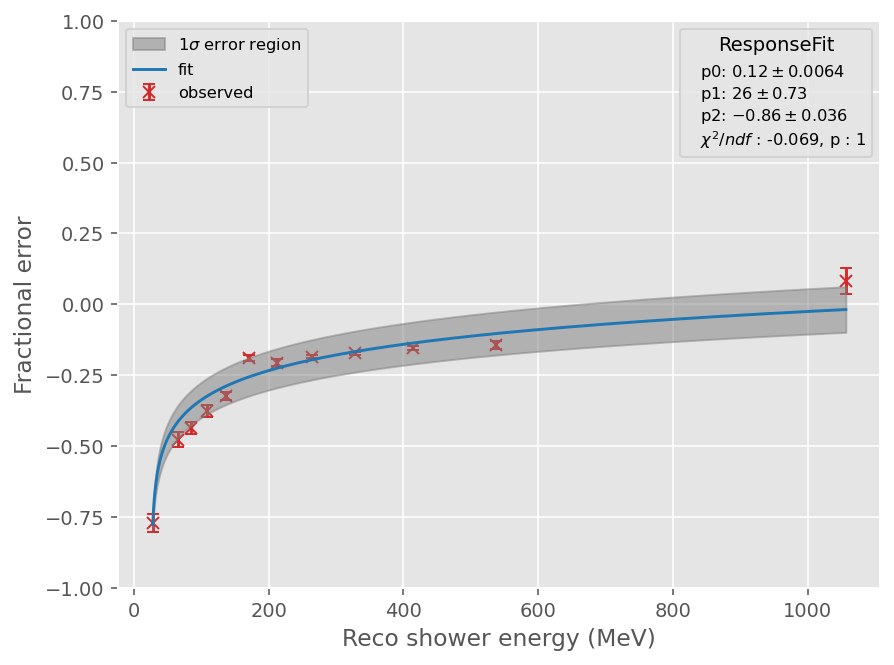

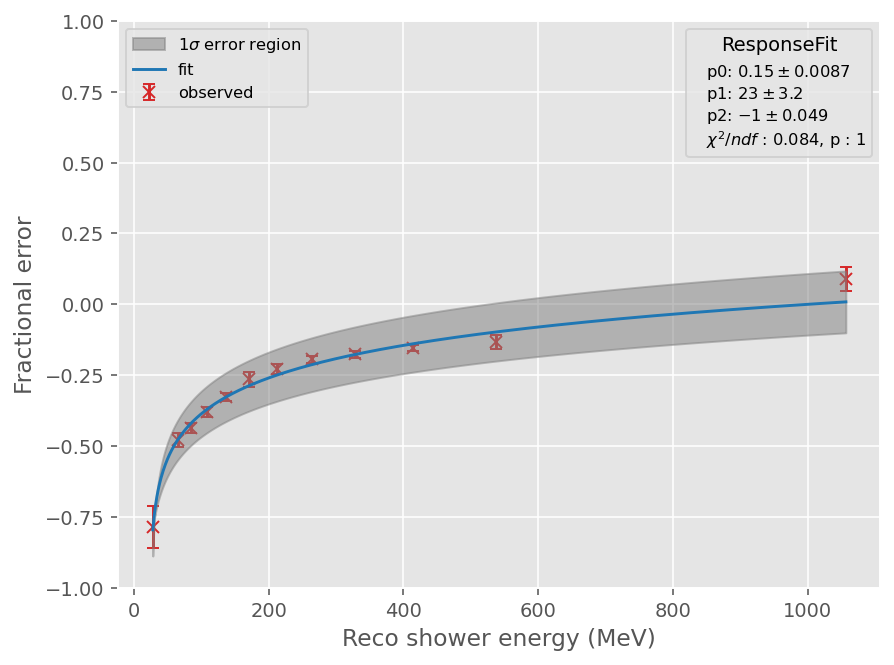

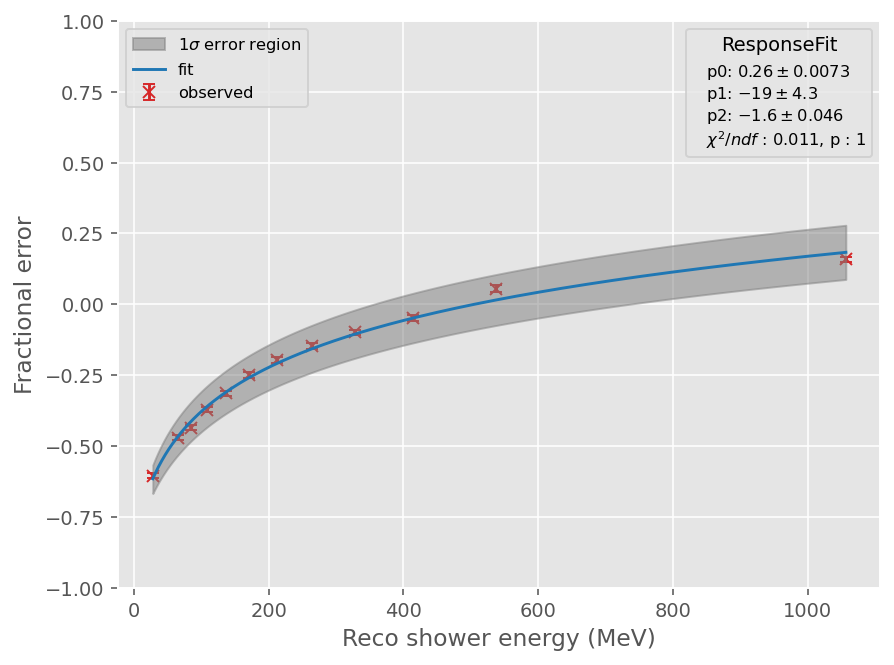

In [10]:
response_params = {}

for i, cv in Plots.IterMultiPlot(central_values):
    print(cv)
    print(central_values[cv][1])
    popt, _ = Fitting.Fit(x, central_values[cv][0], central_values[cv][1], cross_section.EnergyCorrection.ResponseFit, method = "lm", plot = True, xlabel = "Reco shower energy (MeV)", ylabel = "Fractional error", maxfev = int(1E6))
    plt.ylim(-1, 1)
    plt.title(cv)
    response_params[cv] = popt

print(response_params)
pdf.Save()


for cv in central_values:
    plt.figure()
    popt, _ = Fitting.Fit(x, central_values[cv][0], central_values[cv][1], cross_section.EnergyCorrection.ResponseFit, method = "lm", plot = True, xlabel = "Reco shower energy (MeV)", ylabel = "Fractional error", maxfev = int(1E6))
    plt.ylim(-1, 1)
    pdf.Save()
# if save: Plots.Save("respone_fits", path)

# Linear vs response fit

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


uncorrected : mean -0.164 std 0.487

gaussian : mean 0.138 std 1.136

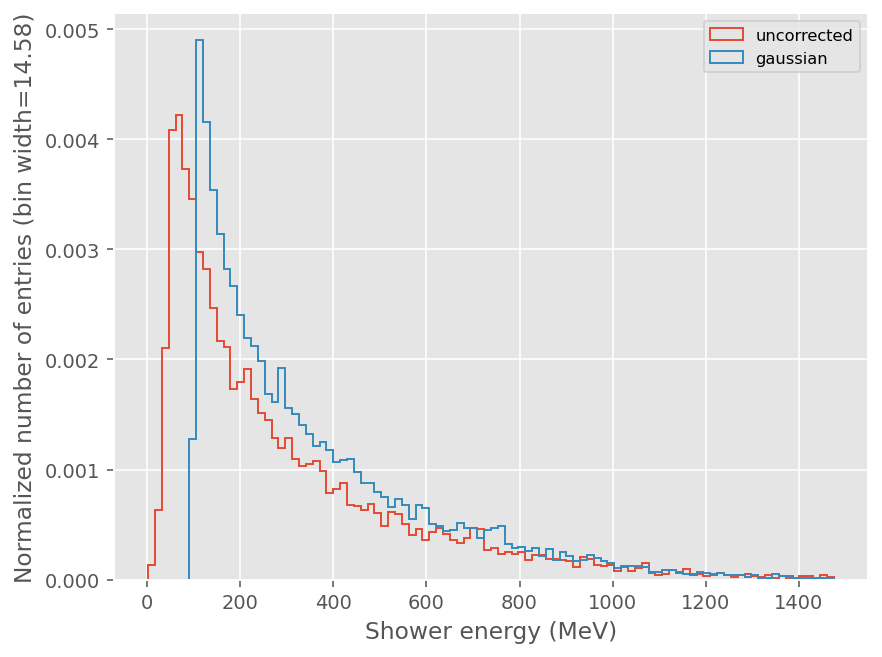

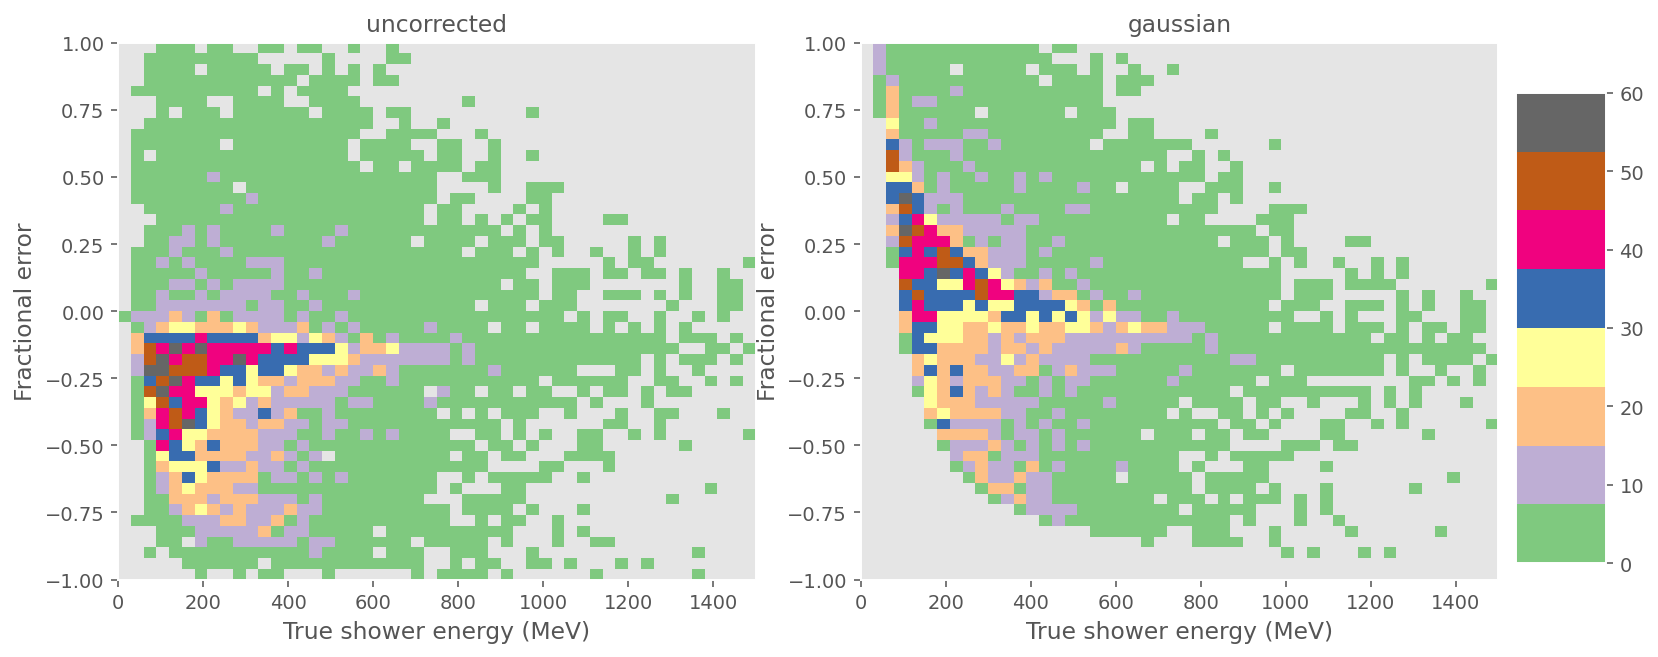

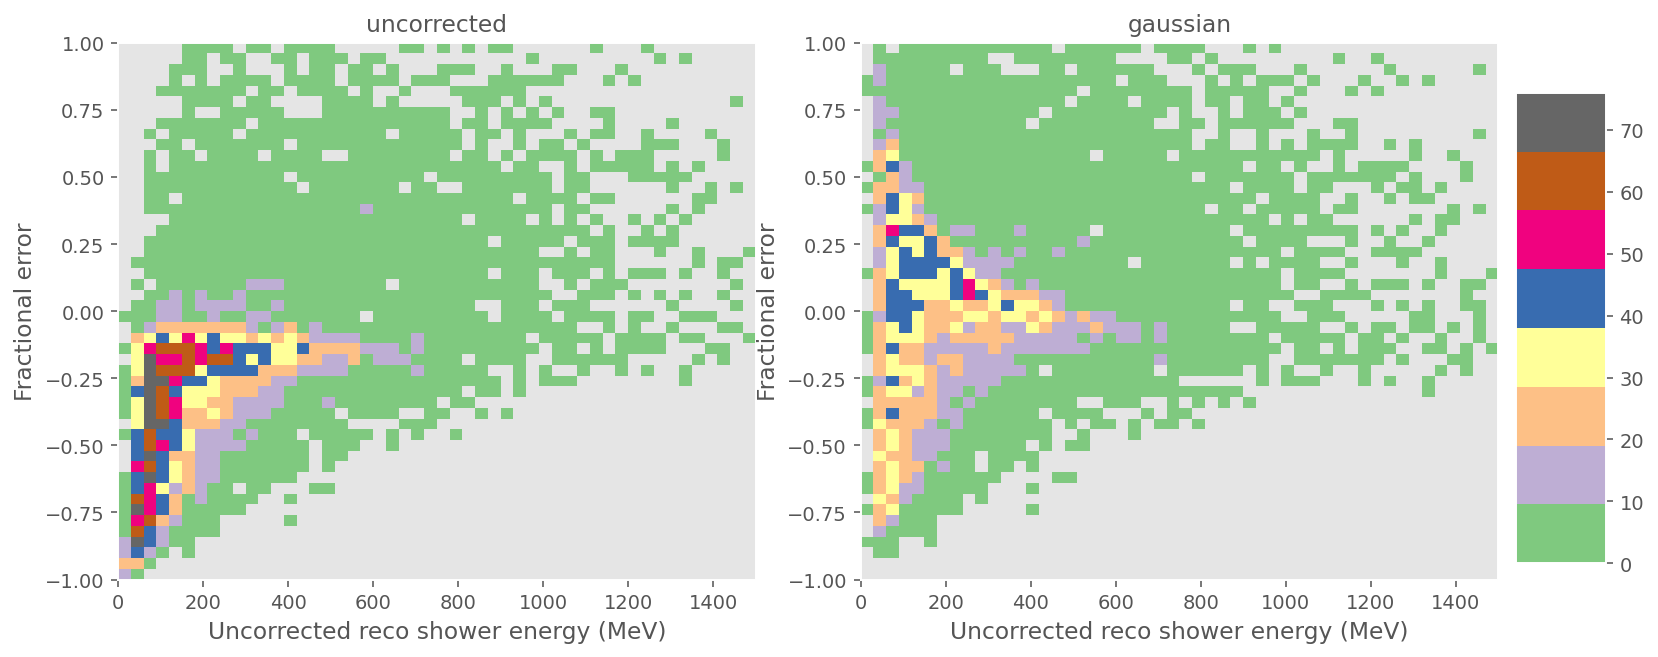

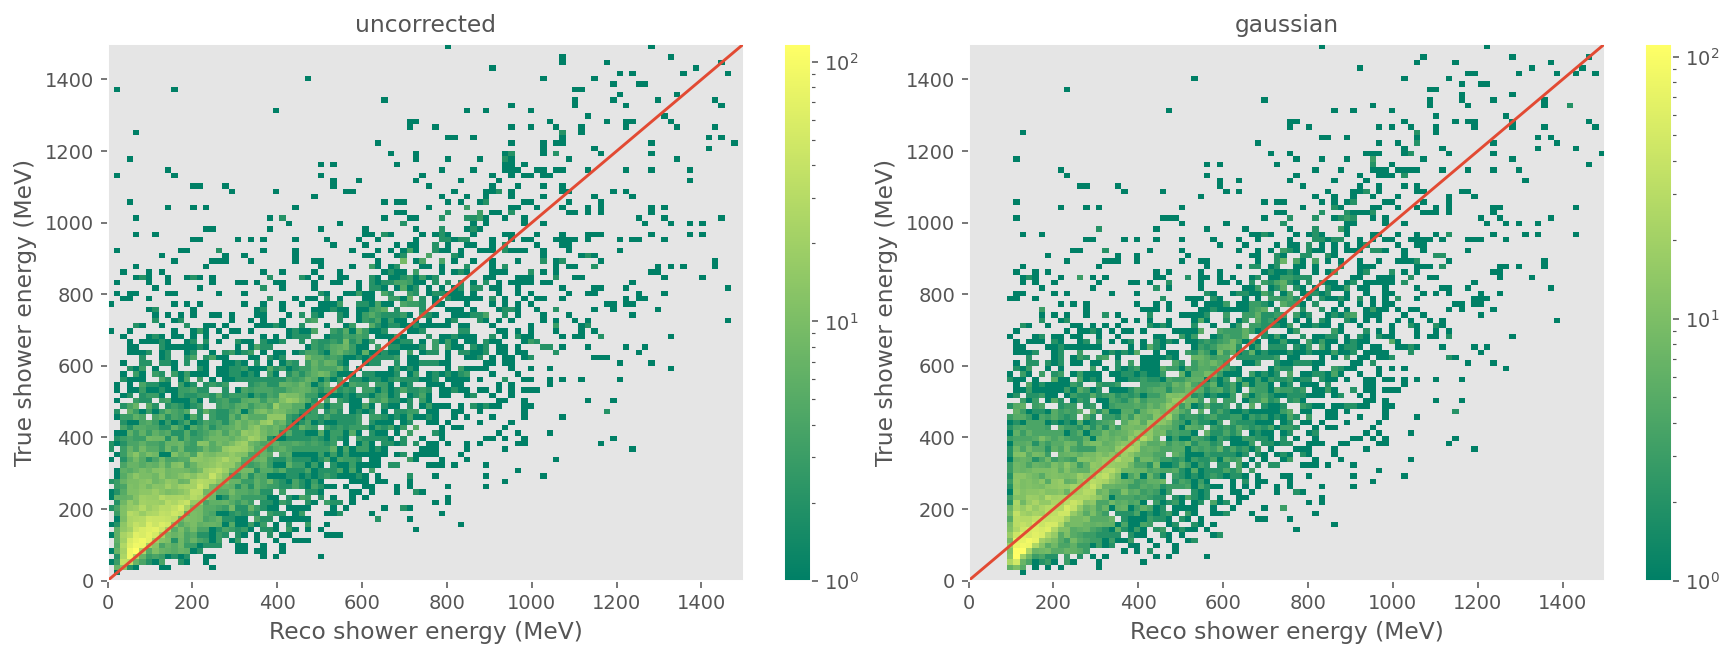

In [11]:
energies = {"uncorrected" : df.reco_energy, "linear" : df.reco_energy / linear_correction}

for p in response_params:
    energies[p] = cross_section.EnergyCorrection.ResponseCorrection(df.reco_energy, *response_params[p])

energies = {"uncorrected" : energies["uncorrected"], "gaussian" : energies["gaussian"]}

Plots.PlotHistComparison(list(energies.values()), labels = list(energies.keys()), x_range = energy_range, xlabel = "Shower energy (MeV)")

fe = {i : (energies[i]/df.true_energy) - 1 for i in energies}

Plots.PlotHist2DComparison([df.true_energy]*len(fe), list(fe.values()), energy_range, [-1, 1], bins = 50, cmap = "Accent", xlabels = ["True shower energy (MeV)"]*len(fe), ylabels = ["Fractional error"]*len(fe), titles = list(fe.keys()))
pdf.Save()

Plots.PlotHist2DComparison([df.reco_energy]*len(fe), list(fe.values()), energy_range, [-1, 1], bins = 50, cmap = "Accent", xlabels = ["Uncorrected reco shower energy (MeV)"]*len(fe), ylabels = ["Fractional error"]*len(fe), titles = list(fe.keys()))
pdf.Save()

for i, (l, e) in Plots.IterMultiPlot(energies.items()):
    Plots.PlotHist2D(e, df.true_energy, bins = 100, title = l, xlabel = "Reco shower energy (MeV)", ylabel = "True shower energy (MeV)", x_range = energy_range, y_range = energy_range, cmap = "summer", newFigure = False)
    plt.plot(energy_range, energy_range)
pdf.Save()

for l, f in fe.items():
    print(f"{l} : mean {f.mean():.3f} std {f.std():.3f}")

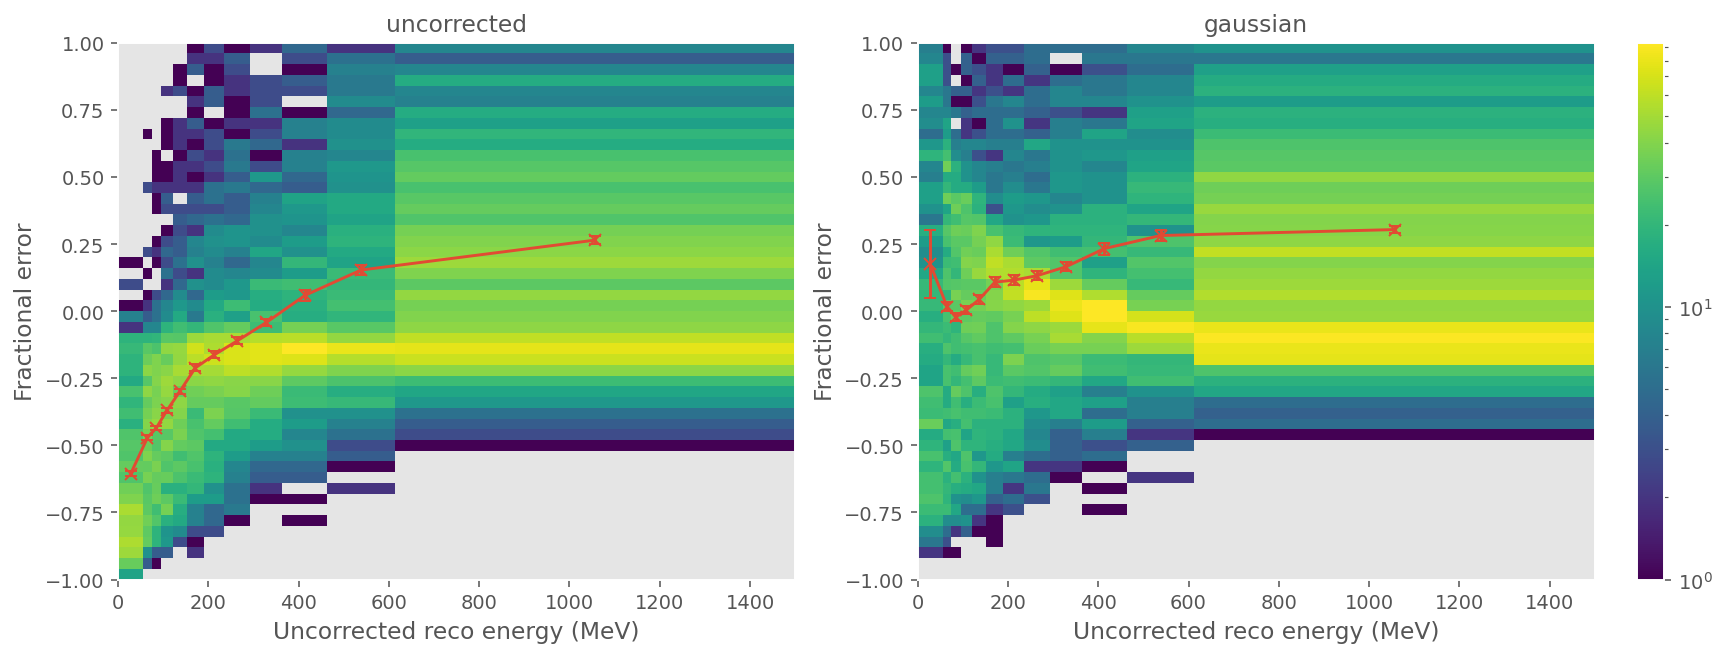

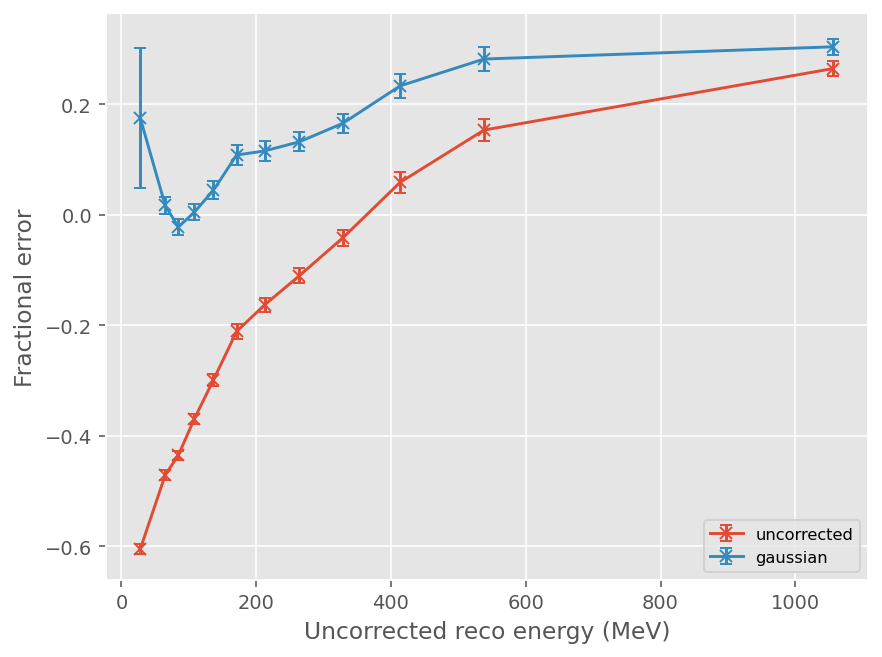

In [12]:
for i, f in Plots.IterMultiPlot(fe):
    binned_data = [fe[f][(df.reco_energy > bins[i + 0]) & (df.reco_energy < bins[i + 1])] for i in range(len(bins)-1)]

    mean = [d.mean() for d in binned_data]
    sem = [d.std()/(len(d)**0.5) for d in binned_data]
    Plots.Plot((bins[1:] + bins[:-1]) / 2, mean, yerr = sem, marker = "x", capsize = 3, newFigure = False)
    Plots.PlotHist2D(df.reco_energy, fe[f], bins = [bins, 50], x_range = energy_range, y_range = [-1, 1], newFigure = False, xlabel = "Uncorrected reco energy (MeV)", ylabel = "Fractional error", title = f)
pdf.Save()

plt.figure()
for i, f in enumerate(fe):
    binned_data = [fe[f][(df.reco_energy > bins[i + 0]) & (df.reco_energy < bins[i + 1])] for i in range(len(bins)-1)]
    mean = [d.mean() for d in binned_data]
    sem = [d.std()/(len(d)**0.5) for d in binned_data]
    Plots.Plot((bins[1:] + bins[:-1]) / 2, mean, yerr = sem, marker = "x", capsize = 3, label = f, newFigure = False)
    plt.xlabel("Uncorrected reco energy (MeV)")
    plt.ylabel("Fractional error")
    plt.legend()
pdf.Save()


# Performance

In [13]:
def UnpackPi0Tags(tags : pd.DataFrame) -> Tags.Tags:
    """ Read tags from dataframe to Tags object.

    Args:
        tags (pd.DataFrame): pi0 tags from file

    Returns:
        Tags.Tags: pi0 tags
    """
    pi0_tags = Tags.Tags()
    for i in range(4):
        pi0_tags[tags.pi0_tags[i].name] = tags.pi0_tags[i]
    return pi0_tags


pairs = pd.read_hdf(photon_file, "photon_pairs")
tags = pd.read_hdf(photon_file, "tags")

mass = {"uncorrected" : Master.ShowerPairs.Mass(pairs.shower_pairs_reco_lead_energy, pairs.shower_pairs_reco_sub_energy, pairs.shower_pairs_reco_angle)}
mass["linear"] = Master.ShowerPairs.Mass(
    cross_section.EnergyCorrection.LinearCorrection(pairs.shower_pairs_reco_lead_energy, linear_correction), 
    cross_section.EnergyCorrection.LinearCorrection(pairs.shower_pairs_reco_sub_energy, linear_correction), 
    pairs.shower_pairs_reco_angle
    )

for p in response_params:
    mass[p] = Master.ShowerPairs.Mass(
        cross_section.EnergyCorrection.ResponseCorrection(pairs.shower_pairs_reco_lead_energy, *response_params[p]),
        cross_section.EnergyCorrection.ResponseCorrection(pairs.shower_pairs_reco_sub_energy,  *response_params[p]),
        pairs.shower_pairs_reco_angle
        )

mass = {"uncorrected" : mass["uncorrected"], "gaussian" : mass["gaussian"]}

/home/sb16165/anaconda3/envs/python3_10_0/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


some tags do not have colours, will override them for the default ones
some tags do not have colours, will override them for the default ones


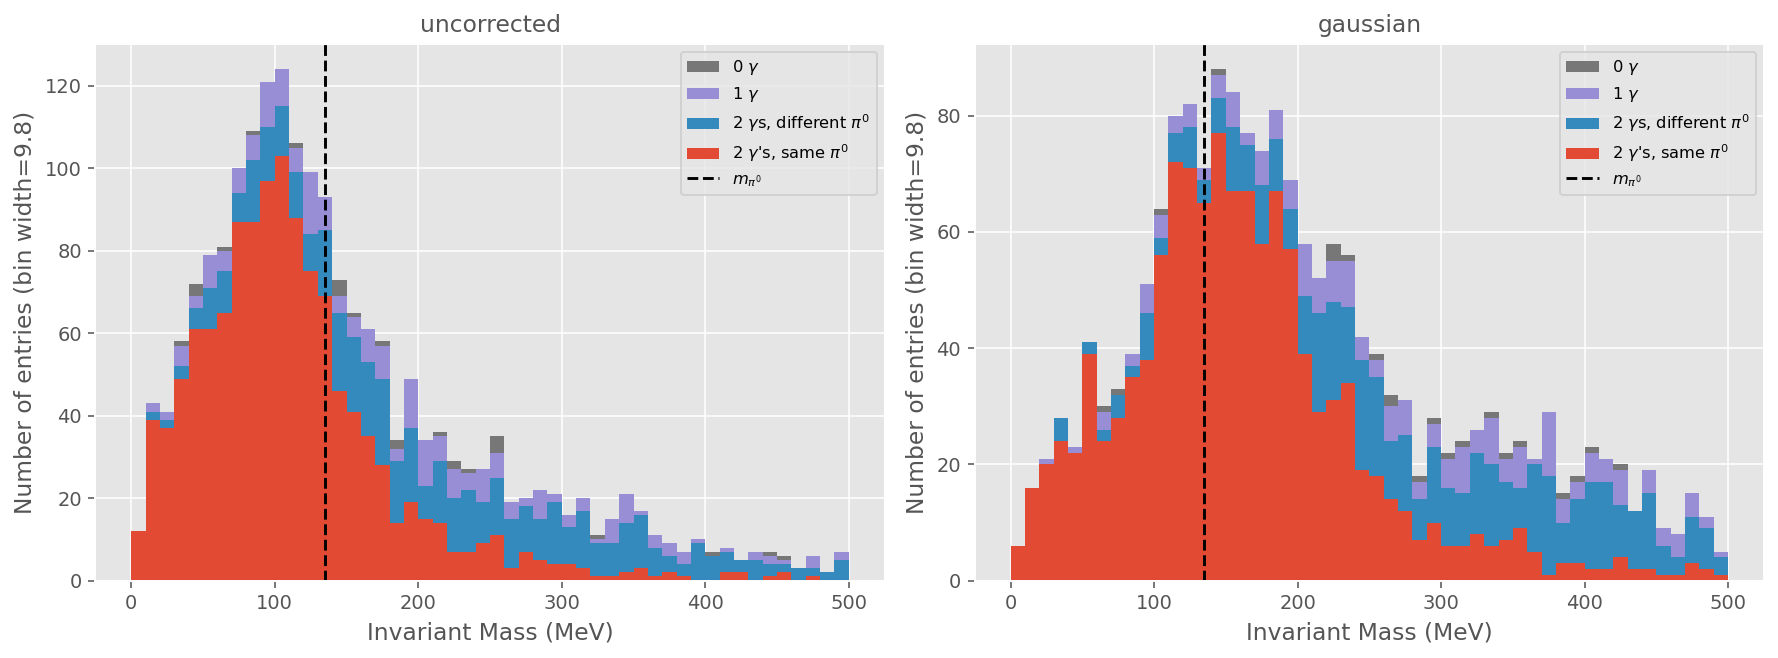

In [14]:
def cut_scan(value : np.array, signal_mask : np.array, nsamples : int = 100) -> tuple:
    """Cut on value, compute purity and efficiency for multiple cut values.

    Args:
        value (np.array): value to cut on
        signal_mask (np.array): mask which defines signal
        nsamples (int, optional): number of cut values to try. Defaults to 100.

    Returns:
        tuple: performance metrics
    """
    cuts = np.nanpercentile(value, np.linspace(1, 99, nsamples))

    s_e = []
    s_p = []
    s_y = []
    b_y = []
    for c in cuts:
        mask = value < c
        s_e.append(np.sum(signal_mask[mask]) / len(signal_mask))
        s_p.append(np.sum(signal_mask[mask]) / len(signal_mask[mask]))
        s_y.append(np.sum(signal_mask[mask]))
        b_y.append(np.sum(~signal_mask[mask]))
        
    s_e = np.array(s_e) # signal efficiency
    s_p = np.array(s_p) # signal purity
    s_y = np.array(s_y) # signal yield
    b_y = np.array(b_y) # background yield
    return s_e, s_p, s_y, b_y, cuts


def optimal_cut(value : np.array, signal_mask : np.array, visualise : bool = False) -> tuple:
    """ Based on metrics from cut_scan, decide which is the best cut value.

    Args:
        value (np.array): value cut on
        signal_mask (np.array): mask which defines signal
        visualise (bool, optional): make plots. Defaults to False.

    Returns:
        tuple: optimal cut and the signal purity and efficiency at that cut
    """

    s_e, s_p, _, _, cuts = cut_scan(value, signal_mask)
    score = s_e * s_p

    best = np.nanargmax(score)
    optimal = cuts[best]

    if visualise:
        Plots.PlotComparison([cuts]*3, [s_e, s_p, score], labels = ["efficiency", "purity", "purity $\\times$ efficiency"], newFigure = False)
        plt.axvline(optimal, linestyle = "--", color = "black", label = f"optimal cut: {optimal:.0f}")
        plt.xlabel("value")
        plt.legend()
        plt.ylim(0, 1)
    return optimal, s_p[best], s_e[best]


def mass_tag_plots(tags : Tags.Tags):
    """ Plot shower pair invariant mass and plot where the optimal cut position would be, for each correction method.

    Args:
        tags (Tags.Tags): _description_
    """
    for i, (l, m) in Plots.IterMultiPlot(mass.items()):
        Plots.PlotTagged(m, tags, title = l, x_range = [0, 500], bins = 50, newFigure = False, x_label = "Invariant Mass (MeV)")
        cut_position, purity, efficiency = optimal_cut(m, tags.number[0].mask)
        plt.axvline(Particle.from_pdgid(111).mass, color = "black", linestyle = "--", label = "$m_{\pi^{0}}$")
        plt.legend()

pi0_tags = UnpackPi0Tags(tags)

mass_tag_plots(pi0_tags)
pdf.Save()


In [15]:
counts = {}
purities = {}
efficiencies = {}
for m in mass:
    print(m)
    cut_position, _, _ = optimal_cut(mass[m], pi0_tags.number[0].mask)
    mask = mass[m] < cut_position

    c = {}
    p = {}
    e = {}
    for t in pi0_tags:
        c[t] = np.sum(pi0_tags[t].mask[mask])
        e[t] = np.sum(pi0_tags[t].mask[mask])/np.sum(pi0_tags[t].mask)
        p[t] = np.sum(pi0_tags[t].mask[mask])/len(pi0_tags[t].mask[mask])
    purities[m] = p
    counts[m] = c
    efficiencies[m] = e

no_cut_counts = {t : np.sum(pi0_tags[t].mask) for t in pi0_tags}
no_cut_purity = {t : np.sum(pi0_tags[t].mask)/len(pi0_tags[t].mask) for t in pi0_tags}

counts = pd.DataFrame(counts)
counts["before cut"] = no_cut_counts
counts.loc["total"] = counts.sum(axis = "rows")
efficiencies = pd.DataFrame(efficiencies)
efficiencies.loc["total"] = efficiencies.sum(axis = "rows")

purities = pd.DataFrame(purities)
purities["before cut"] = no_cut_purity
purities.loc["total"] = purities.sum(axis = "rows")

if save:
    counts.to_latex(path + "mass_perf_counts.tex")
    purities.to_latex(path + "mass_perf_purity.tex")
    efficiencies.to_latex(path + "mass_perf_efficiency.tex")

print(counts)
print(purities)
print(efficiencies)


uncorrected

gaussian

/tmp/ipykernel_9778/843770920.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  counts.to_latex(path + "mass_perf_counts.tex")
/tmp/ipykernel_9778/843770920.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  purities.to_latex(path + "mass_perf_purity.tex")
/tmp/ipykernel_9778/843770920.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature ma

uncorrected  gaussian  before cut
2 $\gamma$'s, same $\pi^{0}$             1140      1102        1231
2 $\gamma$s, different $\pi^{0}$          243       203         513
1 $\gamma$                                140       100         247
0 $\gamma$                                 16        11          30
total                                    1539      1416        2021

uncorrected  gaussian  before cut
2 $\gamma$'s, same $\pi^{0}$         0.740741  0.778249    0.609104
2 $\gamma$s, different $\pi^{0}$     0.157895  0.143362    0.253835
1 $\gamma$                           0.090968  0.070621    0.122217
0 $\gamma$                           0.010396  0.007768    0.014844
total                                1.000000  1.000000    1.000000

uncorrected  gaussian
2 $\gamma$'s, same $\pi^{0}$         0.926076  0.895207
2 $\gamma$s, different $\pi^{0}$     0.473684  0.395712
1 $\gamma$                           0.566802  0.404858
0 $\gamma$                           0.533333  0.366667
total                                2.499896  2.062444

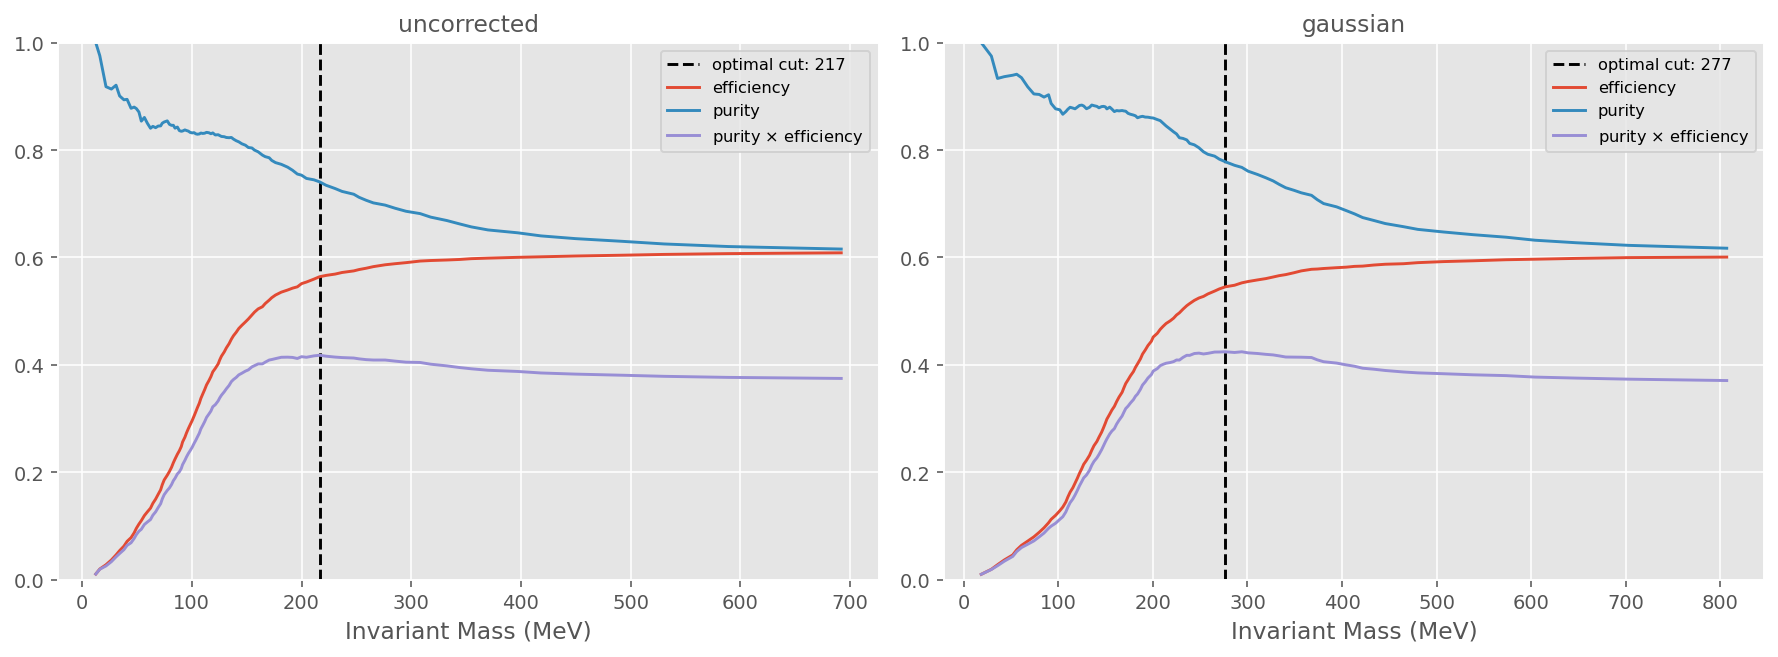

In [16]:
for i, m in Plots.IterMultiPlot(mass):
    optimal_cut(mass[m], pi0_tags.name_simple["pi0s"].mask, True)
    plt.xlabel("Invariant Mass (MeV)")
    plt.title(m)
pdf.Save()


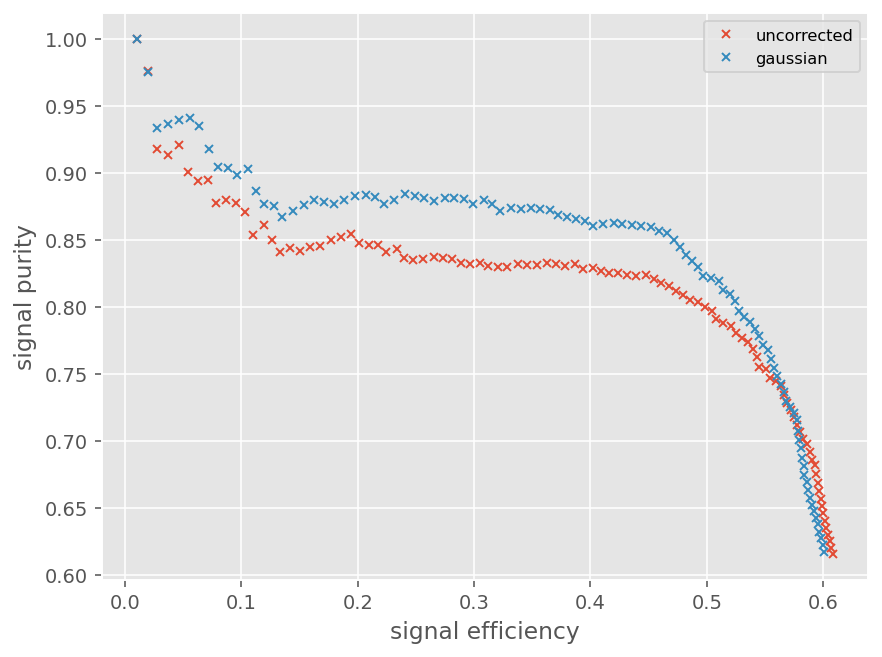

In [17]:
labels = []
efficiencies = []
purities = []

for m in mass:
    if m in ["linear"]: continue
    e, p, _, _, _ = cut_scan(mass[m], pi0_tags.name_simple["pi0s"].mask)
    efficiencies.append(e)
    purities.append(p)
    labels.append(m)

Plots.PlotComparison(efficiencies, purities, marker = "x", labels = labels, xlabel = "signal efficiency", ylabel = "signal purity", markersize = 4, newFigure = False, linestyle="")


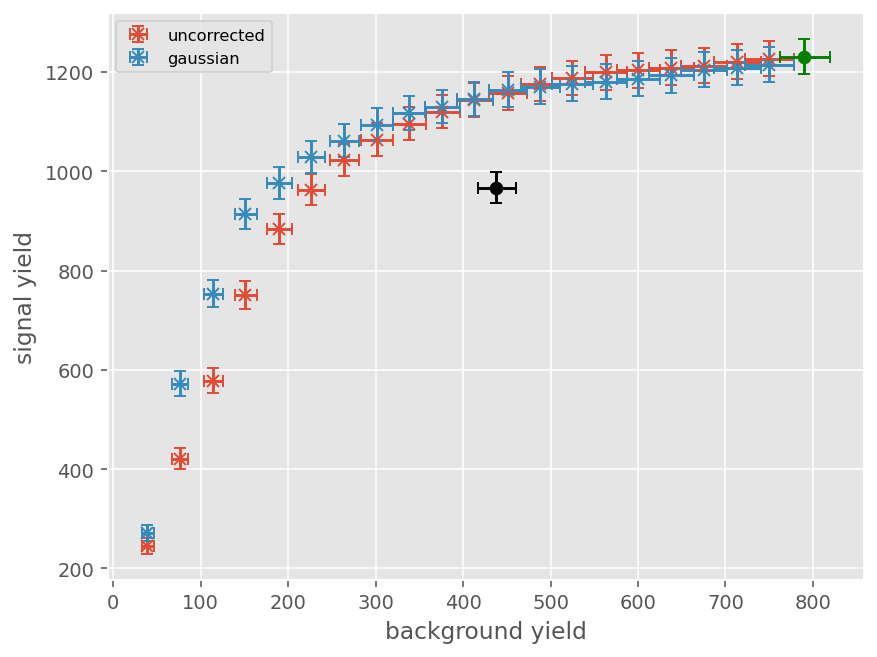

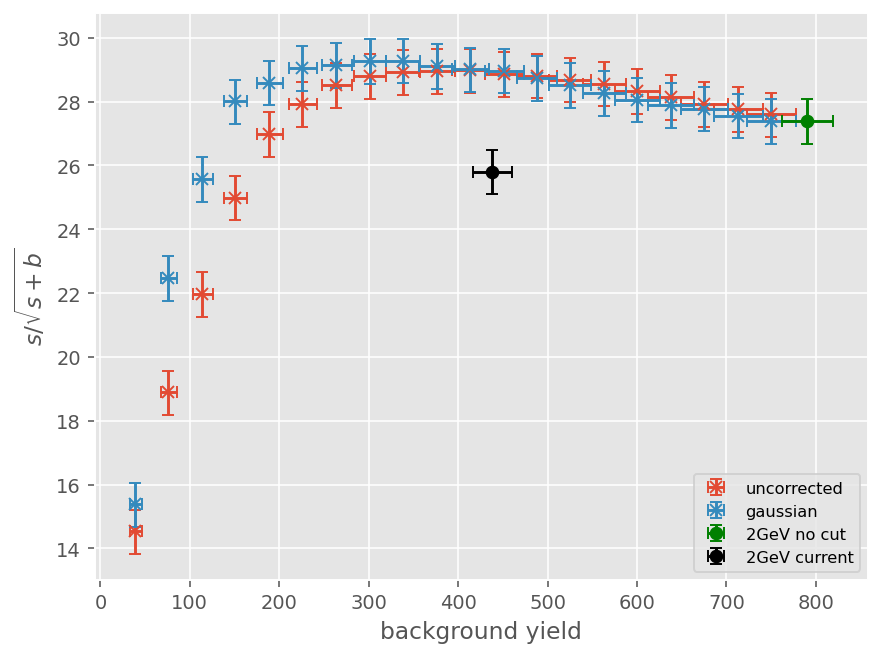

In [18]:
def optimal_cut_yield(value : np.array, signal_mask : np.array) -> tuple:
    """ Metrics to plot optimal cuts, at fixed amounts of background yield.

    Args:
        value (np.array): value to cut
        signal_mask (np.array): signal mask

    Returns:
        tuple: metrics for plots
    """
    n_signal = np.sum(signal_mask)
    n_background = np.sum(~signal_mask)

    sorted_ind = np.argsort(np.array(value))
    sorted_value = np.array(value[sorted_ind])
    sorted_mask = np.array(signal_mask[sorted_ind])

    bkg_yields = np.array(n_background * np.linspace(0.05, 0.95, 20), dtype = int)

    sig_yields = []
    total_yields = []
    cuts = []

    purity = []
    efficiency = []

    for y in bkg_yields:
        cut_value = sorted_value[~sorted_mask][y]
        cuts.append(cut_value)
        sig_yields.append(np.sum(signal_mask[value < cut_value]))
        total_yields.append(len(signal_mask[value < cut_value]))

        purity.append(np.sum(signal_mask[value < cut_value]) / len(signal_mask[value < cut_value]))
        efficiency.append(np.sum(signal_mask[value < cut_value]) / n_signal)

    return np.array(bkg_yields), np.array(sig_yields), np.array(total_yields), np.array(purity), np.array(efficiency), np.array(cuts)


def CorrectionPerformance() -> dict:
    """ Run optimal_cut_yield for each correction.

    Returns:
        dict: metrics
    """
    metrics = {}
    for m in mass:
        by, sy, ty, p, e, cuts = optimal_cut_yield(mass[m], pi0_tags.name_simple["pi0s"].mask)
        metrics[m] = {"background_yield" : by,
         "signal_yield" : sy,
         "total_yield" : ty,
         "purity" : p,
         "efficiency" : e,
         "cuts" : cuts
        }
    return metrics

def binom_error(q : np.array, n : np.array, sigma : float) -> np.array:
    """ Binomial error for stastical uncertainty.

    Args:
        q (np.array): counts
        n (np.array): observations
        sigma (int): confidence interval

    Returns:
        np.array: binomial error
    """
    p = 1 - (stats.norm.cdf(sigma, 0, 1) - stats.norm.cdf(-sigma, 0, 1))
    conf_int = sm.stats.proportion_confint(q, n, p, method = "beta")
    error = abs(q - n * np.array(conf_int))
    return error


def CurrentMassCut(mass : np.array, signak_mask : np.array, ntrials : int, cut : bool = True) -> tuple:
    """ Compute performance for current Invariant mass cut.

    Args:
        mass (np.array): mass
        signak_mask (np.array): signal
        ntrials (int): number of events
        cut (bool, optional): whether to cut data or not before computing metrics. Defaults to True.

    Returns:
        tuple: metrics
    """
    if cut:
        mask = (50 < mass) & (mass < 250)
    else:
        mask = True
    s = np.sum(mask & signak_mask)
    b = np.sum(mask & ~signak_mask)
    s_e = binom_error(s, ntrials, 1)
    b_e = binom_error(b, ntrials, 1)

    return s, b, s_e[:, np.newaxis], b_e[:, np.newaxis]

performance_results = CorrectionPerformance()
trials = 141548
# trials = len(pi0_tags.name_simple["pi0s"].mask)

s_error = {}
b_error = {}
t_error = {}
p_error = {}
ta_error = {}
e_error = {}

for m in mass:
    s_error[m] = binom_error(performance_results[m]["signal_yield"], trials, 1)
    b_error[m] = binom_error(performance_results[m]["background_yield"], trials, 1)

    t_error[m] = binom_error(performance_results[m]["total_yield"], trials, 1)
    p_error[m] = performance_results[m]["purity"] * ((s_error[m]/performance_results[m]["signal_yield"])**2 + (t_error[m]/performance_results[m]["total_yield"])**2)**0.5

    tmp = binom_error(len(pi0_tags.name_simple["pi0s"].mask), trials, 1)
    ta_error[m] =  np.array([[tmp[0]], [tmp[1]]])
    e_error[m] = performance_results[m]["efficiency"] * ((s_error[m]/performance_results[m]["signal_yield"])**2 + (ta_error[m]/len(pi0_tags.name_simple["pi0s"].mask))**2)**0.5

plt.figure()
for m in mass:
    if m in ["linear"]: continue
    Plots.Plot(x = performance_results[m]["background_yield"], y = performance_results[m]["signal_yield"], xerr = b_error[m], yerr = s_error[m], ylabel = "signal yield", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, label = m, newFigure = False)

n2 = CurrentMassCut(mass["uncorrected"], pi0_tags.name_simple["pi0s"].mask, trials, False)
plt.errorbar(n2[1], n2[0], yerr = n2[2], xerr = n2[3], marker = "o", linestyle = "", color = "green", label = "2GeV no cut", capsize = 3)

c2 = CurrentMassCut(mass["uncorrected"], pi0_tags.name_simple["pi0s"].mask, trials)
plt.errorbar(c2[1], c2[0], yerr = c2[2], xerr = c2[3], marker = "o", linestyle = "", color = "black", label = "2GeV current", capsize = 3)

pdf.Save()

# df_1GeV = {
#     "pairs" : pd.read_hdf("test/1GeV_shower_energy/photon_energies.hdf5", "photon_pairs"),
#     "tags" : UnpackPi0Tags(pd.read_hdf("test/1GeV_shower_energy/photon_energies.hdf5", "tags")),
#     "trials" : 298194
# }
# df_1GeV["mass"] = Master.ShowerPairs.Mass(df_1GeV["pairs"].shower_pairs_reco_lead_energy, df_1GeV["pairs"].shower_pairs_reco_sub_energy, df_1GeV["pairs"].shower_pairs_reco_angle)

# print(np.sum(pi0_tags.name_simple["pi0s"].mask))
# print(len(pi0_tags.name_simple["pi0s"].mask))
# print(np.sum(pi0_tags.name_simple["pi0s"].mask) / len(pi0_tags.name_simple["pi0s"].mask))

# print(np.sum(df_1GeV["tags"].name_simple["pi0s"].mask))
# print(len(df_1GeV["tags"].name_simple["pi0s"].mask))
# print(np.sum(df_1GeV["tags"].name_simple["pi0s"].mask) / len(df_1GeV["tags"].name_simple["pi0s"].mask))

# n1 = CurrentMassCut(df_1GeV["mass"], df_1GeV["tags"].name_simple["pi0s"].mask, df_1GeV["trials"], False)
# plt.errorbar(n1[1], n1[0], yerr = n1[2], xerr = n1[3], marker = "x", linestyle = "", color = "green", label = "1GeV no cut", capsize = 3)

# c1 = CurrentMassCut(df_1GeV["mass"], df_1GeV["tags"].name_simple["pi0s"].mask, df_1GeV["trials"])
# plt.errorbar(c1[1], c1[0], yerr = c1[2], xerr = c1[3], marker = "x", linestyle = "", color = "black", label = "1GeV current", capsize = 3)
# plt.legend()

def perf_metric(s, b, s_e, b_e):
    p = s / np.sqrt(b + s)
    p_e = ((s_e / s)**2 + 0.5 * (s + b) / (s_e**2 + b_e**2))**0.5
    return p, p_e

plt.figure()
for m in mass:
    if m in ["linear"]: continue
    p, p_e = perf_metric(performance_results[m]["signal_yield"], performance_results[m]["background_yield"], s_error[m], b_error[m])
    # p = performance_results[m]["signal_yield"] / (performance_results[m]["signal_yield"] + performance_results[m]["background_yield"])**0.5
    # p_e = (s_error[m] / performance_results[m]["signal_yield"])**2 + 0.5 * (performance_results[m]["signal_yield"] + performance_results[m]["background_yield"]) / (s_error[m]**2 + b_error[m]**2)
    Plots.Plot(performance_results[m]["background_yield"], p, xerr = b_error[m], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, label = m, newFigure = False)

p, p_e = perf_metric(n2[0], n2[1], n2[2], n2[3])
Plots.Plot(n2[1], p, xerr = n2[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "o", markersize = 6, color = "green", label = "2GeV no cut", newFigure = False)

p, p_e = perf_metric(c2[0], c2[1], c2[2], c2[3])
Plots.Plot(c2[1], p, xerr = c2[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "o", markersize = 6, color = "black", label = "2GeV current", newFigure = False)

pdf.Save()

# p, p_e = perf_metric(n1[0], n1[1], n1[2], n1[3]) 
# Plots.Plot(n1[1], p, xerr = n1[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, color = "green", label = "1GeV no cut", newFigure = False)

# p, p_e = perf_metric(c1[0], c1[1], c1[2], c1[3]) 
# Plots.Plot(c1[1], p, xerr = c1[3], yerr = p_e, ylabel = "$s / \\sqrt{s + b}$", xlabel = "background yield", capsize = 3, linestyle = "", marker = "x", markersize = 6, color = "black", label = "1GeV current", newFigure = False)


In [19]:
pdf.close()

pdf work/2023/PDSPProd4a_MC_2GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/shower_energy_correction/plots.pdf has been closed


# Output

In [20]:
import json
params = {p : {f"p{i}" : response_params[p][i] for i in range(len(response_params[p]))} for p in response_params}

for name, p in params.items():
    with open(path + name + ".json", "w") as f:
        json.dump(p, f)
